# Setup

### Load libraries

In [3]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import jinja2
import matplotlib.pyplot as plt
from weasyprint import HTML as WPHTML
from weasyprint import CSS
from html2image import Html2Image
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.set_option('display.max_colwidth', 100)

### Load data

In [4]:
root_dirs = [
    "experiments/some_models_all_ex_defs_context",
    "experiments/grok_mini_defs_context",
    "experiments/gemini_thinking_defs_context",
    "experiments/fixing_exercises"
]

data_list = []

for root_dir in root_dirs:
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(subdir, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    
                    # Extract experiment name: first part after "experiments/"
                    experiment_name = os.path.normpath(subdir).split(os.sep)
                    experiment_idx = experiment_name.index("experiments") + 1
                    experiment = experiment_name[experiment_idx]
                    
                    # Extract timestamp: immediate parent folder of JSON file
                    timestamp = os.path.basename(subdir)
                    
                    # Add to data
                    data["experiment"] = experiment
                    data["timestamp"] = timestamp
                    
                    data_list.append(data)
                except json.JSONDecodeError:
                    print(f"Failed to decode JSON: {json_path}")

# Create DataFrame
df = pd.DataFrame(data_list)

# Filter out previously tested unwanted models
exclude_models = ['openai/o4-mini-high', 'openai/gpt-4o-mini']
df = df[~df['model'].isin(exclude_models)]


# Drop Grok 3 Mini from 'some_models_all_ex_defs_context' experiment (invalid data, not used for analysis)
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("x-ai/grok-3-mini-beta"))
)]

# Drop Gemini:thinking models from 'some_models_all_ex_defs_context' experiment (invalid data, not used for analysis)
df = df[~(
    (df['experiment'] == 'some_models_all_ex_defs_context') &
    (df['model'].str.contains("google/gemini-2.5-flash-preview-05-20:thinking"))
)]

# Define a composite run identifier
df['full_run_id'] = df['experiment'] + ' | ' + df['timestamp'] + ' | ' + df['run_id']

# Keep everything from fixing_exercises
df_fix = df[df['experiment'] == 'fixing_exercises']

# From all other experiments, exclude exercises starting with '2_' or '5_'
df_other = df[
    (df['experiment'] != 'fixing_exercises') &
    (~df['exercise'].str.startswith('2_')) &
    (~df['exercise'].str.startswith('5_'))
]

# Combine back together
df = pd.concat([df_fix, df_other], ignore_index=True)


len(df)


3252

In [5]:
# Mapping for clean model names
pretty_names = {
    "anthropic/claude-sonnet-4": "Claude Sonnet 4",
    "google/gemini-2.5-flash-preview-05-20": "Gemini 2.5 Flash",
    "openai/gpt-4.1": "GPT-4.1",
    "x-ai/grok-3-beta": "Grok 3",
    "x-ai/grok-3-mini-beta": "Grok 3 Mini",
    "openai/o4-mini": "o4-mini",
    "google/gemini-2.5-flash-preview-05-20:thinking": "Gemini 2.5 Flash (thinking)",
}

df["model"] = df["model"].map(pretty_names)

### All run data in general (also outside of experiments) 

In [6]:
root_dir = "."
data_list = []

# Define which top-level directories to include
target_dirs = {"experiments"}  # exact match
prefix_dirs = {"responses_old"}  # match by prefix

for subdir, _, files in os.walk(root_dir):
    # Get the top-level directory inside root_dir
    parts = os.path.normpath(subdir).split(os.sep)
    if len(parts) < 2:
        continue
    top_level = parts[0]  # e.g., "experiments", "responses_old2"

    # Check if we should include this directory
    if top_level not in target_dirs and not any(top_level.startswith(p) for p in prefix_dirs):
        continue

    for file in files:
        if file.endswith('.json'):
            json_path = os.path.join(subdir, file)
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Use directory name as experiment and timestamp
                experiment = top_level
                timestamp = os.path.basename(subdir)

                data["experiment"] = experiment
                data["timestamp"] = timestamp
                data_list.append(data)

            except json.JSONDecodeError:
                print(f"Failed to decode JSON: {json_path}")

# Convert to DataFrame
df_all = pd.DataFrame(data_list)
print(f"Total records extracted: {len(df_all)}")

Total records extracted: 8885


### Display incomplete runs (check that all runs are complete)

In [7]:
def find_incomplete_runs(df):
    """
    Returns a DataFrame of runs that:
    - Used fewer than the allowed max_attempts
    - Were not successful
    Includes columns: full_run_id, exercise
    """
    # Determine final attempt and success per run
    run_summary = df.groupby('full_run_id').agg({
        'attempt': 'max',
        'max_attempts': 'max',
        'success': 'max'
    }).reset_index()

    # Filter for incomplete, unsuccessful runs
    incomplete = run_summary[
        (run_summary['attempt'] < run_summary['max_attempts']) &
        (run_summary['success'] == False)
    ]

    # Attach exercise info
    exercise_lookup = df[['full_run_id', 'exercise']].drop_duplicates()
    result = incomplete.merge(exercise_lookup, on='full_run_id')

    return result[['full_run_id', 'exercise']]


In [8]:
incomplete_df = find_incomplete_runs(df)
if not incomplete_df.empty:
    print(incomplete_df.to_string(index=False))


# Case-by-case data analysis

### Helper function: Display diff between proof revisions

In [9]:
from IPython.display import display, HTML
import difflib
import html

def show_proof_diff(df_run, attempt_number_1, attempt_number_2):
    # Extract proofs
    proof_1 = df_run[df_run['attempt'] == attempt_number_1]['output'].iloc[0]
    proof_2 = df_run[df_run['attempt'] == attempt_number_2]['output'].iloc[0]

    # Extract additional info
    error_1 = df_run[df_run['attempt'] == attempt_number_1]['errors'].iloc[0]
    error_2 = df_run[df_run['attempt'] == attempt_number_2]['errors'].iloc[0]

    line_with_error_1 = df_run[df_run['attempt'] == attempt_number_1]['line_with_error'].iloc[0]
    line_with_error_2 = df_run[df_run['attempt'] == attempt_number_2]['line_with_error'].iloc[0]

    # Escape additional info
    escaped_error_1 = html.escape(error_1.split('Error:', 1)[1].strip()) if isinstance(error_1, str) and 'Error:' in error_1 else html.escape(error_1) if isinstance(error_1, str) else ''
    escaped_error_2 = html.escape(error_2.split('Error:', 1)[1].strip()) if isinstance(error_2, str) and 'Error:' in error_2 else html.escape(error_2) if isinstance(error_2, str) else ''

    escaped_line_with_error_1 = html.escape(line_with_error_1) if isinstance(line_with_error_1, str) else ''
    escaped_line_with_error_2 = html.escape(line_with_error_2) if isinstance(line_with_error_2, str) else ''

    # Split into lines and compute diff
    proof_1_lines = proof_1.splitlines()
    proof_2_lines = proof_2.splitlines()

    diff = list(difflib.ndiff(proof_1_lines, proof_2_lines))

    # Process diff for left and right columns
    left_col = []
    right_col = []

    for line in diff:
        tag = line[:2]
        content = html.escape(line[2:])  # escape <, >, &, etc.

        if tag == '  ':
            left_col.append(f"<div>{content}</div>")
            right_col.append(f"<div>{content}</div>")
        elif tag == '- ':
            left_col.append(f"<div style='background-color:#441111;'>{content}</div>")
            right_col.append(f"<div style='background-color:#222222;'></div>")
        elif tag == '+ ':
            left_col.append(f"<div style='background-color:#222222;'></div>")
            right_col.append(f"<div style='background-color:#114411;'>{content}</div>")
        elif tag == '? ':
            # ignore helper lines like ^^^^^^ in diffs
            continue

    # Combine columns into HTML → vertical layout
    html_table = f"""
    <div style="font-family: monospace; background-color: #1e1e1e; color: white; padding: 10px;">
        <div style="padding-bottom: 20px;">
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_1}</div>
            {''.join(left_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_1}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_1}</div>
            </div>
        </div>
        <div>
            <div style="font-weight: bold; padding-bottom: 5px;">Attempt {attempt_number_2}</div>
            {''.join(right_col)}
            <div style="padding-top: 10px; color: #aaaaaa;">
                <div><b>Error:</b> {escaped_error_2}</div>
                <div><b>Line with error:</b> {escaped_line_with_error_2}</div>
            </div>
        </div>
    </div>
    """

    display(HTML(html_table))


### Inspect example data entry

In [10]:
pd.set_option('display.max_colwidth', 100)
df.iloc[0].to_frame()

,0
model,Claude Sonnet 4
exercise,5_9_1
prompt,"You are asked to write a proof in the syntax of Waterproof, a theorem proving educational softwa..."
tutorial,# Waterproof Tutorial\n\n## 1. We conclude that\n\n### Example:\n\nLemma example_reflexivity :\n...
full_input,"Your proof seems to have some mistakes in it, as it does not compile correctly.\nHere is the err..."
exercise_content,"Section Prop_5_4_1.\n\nContext (X : Metric_Space).\nNotation ""'dist(' x , y )"" := (dist X x y)\n..."
output,"Proof.\nWe need to show that (∀ ε > 0, ∃ N1 ∈ ℕ, ∀ n ≥ N1, dist(a(n), p) < ε).\nTake ε > 0.\nWe ..."
token_count,6342
input_tokens,6084
thinking_tokens,0


### See number of runs per model

In [11]:
# Count number of unique runs per model
runs_per_model = df[['model', 'full_run_id']].drop_duplicates().groupby('model').size().reset_index(name='num_runs')

# Optional: sort by num_runs descending
runs_per_model = runs_per_model.sort_values(by='num_runs', ascending=False)

# Display
runs_per_model

,model,num_runs
0,Claude Sonnet 4,27
1,GPT-4.1,27
2,Gemini 2.5 Flash,27
3,Gemini 2.5 Flash (thinking),27
4,Grok 3,27
5,Grok 3 Mini,27
6,o4-mini,27


In [12]:
df_all["model"].value_counts()


model
openai/gpt-4.1                                    2495
google/gemini-2.5-flash-preview-05-20:thinking    2027
google/gemini-2.5-flash-preview-05-20             1477
x-ai/grok-3-mini-beta                             1449
anthropic/claude-sonnet-4                          619
openai/o4-mini                                     331
x-ai/grok-3-beta                                   279
deepseek/deepseek-chat-v3-0324                      58
openai/o3-mini                                      42
deepseek/deepseek-r1-0528                           18
o3-mini                                             16
anthropic/claude-3.7-sonnet:thinking                13
o4-mini                                             12
openai/o4-mini-high                                  8
openai/gpt-4o-mini                                   8
gemini-2.5-flash-preview-04-17                       5
deepseek/deepseek-r1:free                            3
deepseek/deepseek-chat-v3-0324:free                  3
deep

### Inspect runs per model

In [77]:
models_of_interest = [
    "Claude Sonnet 4",
    "Gemini 2.5 Flash (thinking)",
    "GPT-4.1"
]

model_to_inspect = "Claude Sonnet 4"

# Filter to the model of interest
df_model = df[df['model'] == model_to_inspect].copy()

# Get unique runs
unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

# Optionally show the run IDs for inspection
for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")


Number of unique runs for model 'Claude Sonnet 4': 27
0: fixing_exercises | 2025-06-15_00-25-19 | anthropic/claude-sonnet-4::5_9_1::1
1: fixing_exercises | 2025-06-15_00-28-44 | anthropic/claude-sonnet-4::5_9_2::1
2: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_reflexive_2::1
3: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_triangle_inequality_2::1
4: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_positive_2::1
5: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_reflexive_1::1
6: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_symmetric_2::1
7: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_positive_1::1
8: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_symmetric_1::1
9: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_triangle_inequality_1::1
10: fixing_exercises | 2025-06-14_23-39-11 | anthropic/claude-so

### Inspect errors in a particular run

In [78]:
# Select the Nth run (e.g. first one)
run_index = 16 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

# Filter rows corresponding to this run
df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

# Clean up error message
df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

# Show trace table
df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]


,model,exercise,attempt,error_message,line_with_error
1633,Claude Sonnet 4,6_8_2,1,Error:\n`Take ...` can only be used to prove a `for all`-statement (∀) or to construct a map (→)...,Take M ∈ ℝ.
1830,Claude Sonnet 4,6_8_2,2,Error:\nSyntax error: 'it' or 'we' 'conclude' expected after [constr] (in [ltac2_expr]).\n\n,"By the assumption it holds that (∃ N1 ∈ ℕ, ∀ n ≥ N1, a(n) > -M)."
1198,Claude Sonnet 4,6_8_2,3,"Error: Syntax error: ',' or 'in' '(' expected (in [ltac2_expr]).\n\n",Use M := (-M) in the assumption.
1285,Claude Sonnet 4,6_8_2,4,"Error: Syntax error: ',' or 'in' '(' expected (in [ltac2_expr]).\n\n",Use M := (-M) in the assumption (a _diverges to ∞_).
1374,Claude Sonnet 4,6_8_2,5,Error: `Use ... in (*)` only works if (*) starts with a for-all quantifier.\n\n,Use M := (-M) in (i).
1580,Claude Sonnet 4,6_8_2,6,Error:\nSyntax error: 'it' or 'we' 'conclude' expected after [constr] (in [ltac2_expr]).\n\n,"By the assumption it holds that (∃ N1 ∈ ℕ, ∀ n ≥ N1, a(n) > -M)."
1154,Claude Sonnet 4,6_8_2,7,"Error:\n((@seal)(ℕ ⇨ Prop, funz : ℕ ⇨ Prop↦\n ∃ N1,\n z(N1...","By (i) we conclude that (∃ N1 ∈ ℕ, ∀ n ≥ N1, a(n) > -M)."
1732,Claude Sonnet 4,6_8_2,8,"Warning: Expected variable name N2 instead of N1.\nFile ""/tmp/E6_8_2_4yhwdoov.v"", line 61, chara...",Choose N1 := (N1).
1613,Claude Sonnet 4,6_8_2,9,"Warning: Expected variable name N2 instead of N1.\nFile ""/tmp/E6_8_2_v5z6jkpv.v"", line 61, chara...",Choose N1 := (N1).
1597,Claude Sonnet 4,6_8_2,10,Error: Wrong goal specified.\n\n,We need to show that (-a(n) < -M).


In [79]:
show_proof_diff(df_run, 1, 2)

### Total cost estimation

In [16]:
total_cost = df['cost'].sum()
total_cost

np.float64(29.84843835)

# Aggregate data analysis

### Success rate per model

In [17]:
# Group by model and run, compute per-run success (1 if any attempt succeeded)
per_run_success = df.groupby(['model', 'full_run_id'])['success'].max().reset_index()

# Aggregate per model: success_rate, total_runs, successful_runs
agg_success_rate = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % for display
agg_success_rate['success_rate'] = agg_success_rate['success_rate'] * 100

# Optional: round to 1 decimal place
agg_success_rate['success_rate'] = agg_success_rate['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate = agg_success_rate[['model', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Display the table
agg_success_rate

,model,successful_runs,total_runs,success_rate
0,Claude Sonnet 4,18,27,66.7
1,GPT-4.1,17,27,63.0
3,Gemini 2.5 Flash (thinking),16,27,59.3
4,Grok 3,15,27,55.6
5,Grok 3 Mini,13,27,48.1
2,Gemini 2.5 Flash,12,27,44.4
6,o4-mini,12,27,44.4


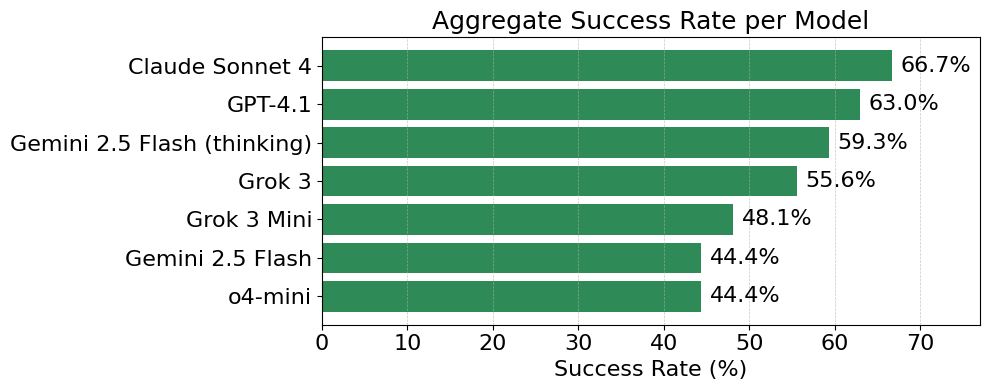

In [18]:
# Plot success_rate per model
plt.figure(figsize=(10, 4))

plt.barh(
    agg_success_rate['model'],
    agg_success_rate['success_rate'],
    color='seagreen'
)

# Invert y-axis so best model is at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=16)
plt.xlim(0,77)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Aggregate Success Rate per Model', fontsize=18)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
for i, v in enumerate(agg_success_rate['success_rate']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=16)

plt.tight_layout()
plt.savefig('Figures/success_rate_models.pdf', bbox_inches='tight')
plt.show()

### Success rate per exercise

In [19]:
# Group by exercise and run, compute per-run success
per_run_success_ex = df.groupby(['exercise', 'full_run_id'])['success'].max().reset_index()

# Aggregate per exercise
agg_success_rate_ex = per_run_success_ex.groupby('exercise')['success'].agg(['mean', 'count', 'sum']).reset_index()

# Rename columns for clarity
agg_success_rate_ex.rename(columns={
    'mean': 'success_rate',
    'count': 'total_runs',
    'sum': 'successful_runs'
}, inplace=True)

# Convert success_rate to % and round
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'] * 100
agg_success_rate_ex['success_rate'] = agg_success_rate_ex['success_rate'].round(1)

# Reorder columns: successful_runs, total_runs, success_rate, sort by success_rate descending
agg_success_rate_ex = agg_success_rate_ex[['exercise', 'successful_runs', 'total_runs', 'success_rate']].sort_values(by='success_rate', ascending=False)

# Make exercise labels nicer
label_mapping = {
    "2_non_degenerate_1": "2.7.1n",
    "2_non_degenerate_2": "2.7.3n",
    "2_positive_1": "2.7.1p",
    "2_positive_2": "2.7.3p",
    "2_reflexive_1": "2.7.1r",
    "2_reflexive_2": "2.7.3r",
    "2_symmetric_1": "2.7.1s",
    "2_symmetric_2": "2.7.3s",
    "2_triangle_inequality_1": "2.7.1t",
    "2_triangle_inequality_2": "2.7.3t",
    "3_11_1": "3.11.1",
    "3_11_2": "3.11.2",
    "3_11_4": "3.11.4",
    "4_9_1": "4.9.1",
    "4_9_2": "4.9.2",
    "4_9_3": "4.9.3",
    "5_9_1": "5.9.1",
    "5_9_2": "5.9.2",
    "6_8_1": "6.8.1",
    "6_8_2": "6.8.2",
    "10_7_3": "10.7.3",
    "10_7_6": "10.7.6",
    "10_7_intermediate": "10.7.3i",
    "11_not_open": "11.no",
    "11_not_closed": "11.nc",
    "13_11_2": "13.11.2",
    "13_11_3": "13.11.3",
}

agg_success_rate_ex['exercise'] = agg_success_rate_ex['exercise'].apply(lambda x: label_mapping.get(x, x))


# Display the table
agg_success_rate_ex


,exercise,successful_runs,total_runs,success_rate
2,10.7.3i,7,7,100.0
10,2.7.3p,7,7,100.0
9,2.7.1p,7,7,100.0
8,2.7.3n,7,7,100.0
17,3.11.1,7,7,100.0
12,2.7.3r,7,7,100.0
11,2.7.1r,7,7,100.0
13,2.7.1s,6,7,85.7
18,3.11.2,6,7,85.7
15,2.7.1t,6,7,85.7


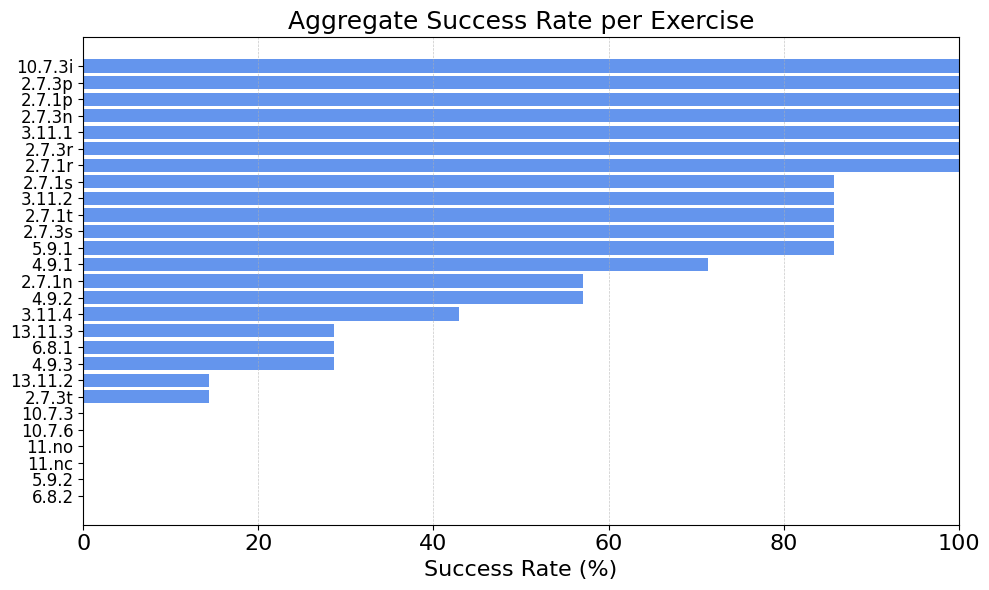

In [20]:
# Plot success_rate per exercise
plt.figure(figsize=(10, 6))

plt.barh(
    agg_success_rate_ex['exercise'],
    agg_success_rate_ex['success_rate'],
    color='cornflowerblue'
)

# Invert y-axis so best exercises appear at the top
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=16)
plt.xlim(0,100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.title('Aggregate Success Rate per Exercise', fontsize=18)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with success rate
#for i, v in enumerate(agg_success_rate_ex['success_rate']):
#    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('Figures/success_rate_exercises.pdf', bbox_inches='tight')
plt.show()

### Attempts used per exercise

In [21]:
# Calculate average number of attempts per successful run per exercise
# and average % of attempts used (attempt / max_attempts)

# Step 1: determine for each run how many attempts were used
run_attempt_stats = df.groupby(['exercise', 'full_run_id']).agg({
    'model': 'first',
    'success': 'max',
    'attempt': 'max',
    'max_attempts': 'max'
}).reset_index()

# Step 2: compute percentage of attempts used
run_attempt_stats['pct_attempts_used'] = (run_attempt_stats['attempt'] / run_attempt_stats['max_attempts']) * 100

# Step 3: compute average number of attempts per successful run
# and average percentage of attempts used (on all runs)

# a) Average attempts used per successful run 
# (only successful ones : [run_attempt_stats['success'] == True])
avg_attempts_per_success = run_attempt_stats.groupby('exercise')['attempt'].mean().reset_index()
avg_attempts_per_success.rename(columns={'attempt': 'avg_attempts_per_success'}, inplace=True)

# b) Average percentage of attempts used across all runs
avg_pct_used = run_attempt_stats.groupby('exercise')['pct_attempts_used'].mean().reset_index()
avg_pct_used.rename(columns={'pct_attempts_used': 'avg_pct_attempts_used'}, inplace=True)

# Step 4: merge into one summary table
exercise_efficiency = pd.merge(avg_attempts_per_success, avg_pct_used, on='exercise')

# Round values
exercise_efficiency['avg_attempts_per_success'] = exercise_efficiency['avg_attempts_per_success'].round(2)
exercise_efficiency['avg_pct_attempts_used'] = exercise_efficiency['avg_pct_attempts_used'].round(1)
exercise_efficiency = exercise_efficiency.sort_values(by='avg_pct_attempts_used', ascending=True)

### Success rate per model and exercise

In [22]:
# Group by model, exercise, run — compute per-run success
per_run_success_grid = df.groupby(['model', 'exercise', 'full_run_id'])['success'].max().reset_index()

# Now pivot: model as rows, exercise as columns, value = mean per run (in %)
grid = per_run_success_grid.pivot_table(
    index='model',
    columns='exercise',
    values='success',
    aggfunc='mean'
) * 100

# Round nicely
grid = grid.round(1)

# Make labels nice
grid.rename(columns=label_mapping, inplace=True)

# Display the grid
grid


exercise,10.7.3,10.7.6,10.7.3i,11.nc,11.no,13.11.2,13.11.3,2.7.1n,2.7.3n,2.7.1p,...,3.11.1,3.11.2,3.11.4,4.9.1,4.9.2,4.9.3,5.9.1,5.9.2,6.8.1,6.8.2
model,,,,,,,,,,,,,,,,,,,,,
Claude Sonnet 4,0.0,0.0,100.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,100.0,100.0,0.0,100.0,0.0
GPT-4.1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0
Gemini 2.5 Flash,0.0,0.0,100.0,0.0,0.0,100.0,0.0,100.0,100.0,100.0,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
Gemini 2.5 Flash (thinking),0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,100.0,100.0,0.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0
Grok 3,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0
Grok 3 Mini,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,100.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0
o4-mini,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,...,100.0,100.0,0.0,100.0,100.0,0.0,100.0,0.0,0.0,0.0


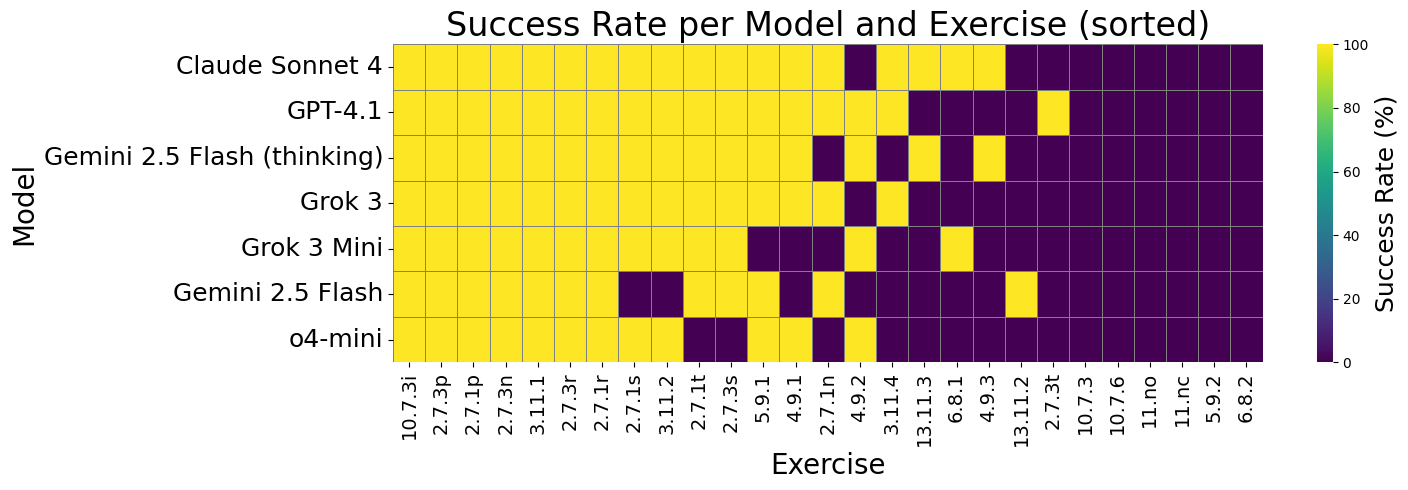

In [23]:
# Compute overall success rate per model and exercise
model_order = grid.mean(axis=1).sort_values(ascending=False).index.tolist()
exercise_order = grid.mean(axis=0).sort_values(ascending=False).index.tolist()

# Plot heatmap
plt.figure(figsize=(15, 5))

sns.heatmap(
    grid.loc[model_order, exercise_order],
    annot=False, fmt='.1f', cmap='viridis', linewidths=0.5, linecolor='gray',
    cbar_kws={'label': 'Success Rate (%)'}
)

cbar = plt.gca().collections[0].colorbar
cbar.ax.set_ylabel('Success Rate (%)', fontsize=18)

# Labels and title
plt.xlabel('Exercise', fontsize=20)
plt.ylabel('Model', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=14)
plt.title('Success Rate per Model and Exercise (sorted)', fontsize=24)

plt.tight_layout()
plt.savefig('Figures/success_rate_heatmap.pdf', bbox_inches='tight')
plt.show()


### Average output token counts per model

In [24]:
# Average output token counts per model
output_tokens_avg = df.groupby('model')['output_tokens'].mean().reset_index()
output_tokens_avg.rename(columns={'output_tokens': 'Avg Output Tokens'}, inplace=True)

# Average thinking token counts per model
thinking_tokens_avg = df.groupby('model')['thinking_tokens'].mean().reset_index()
thinking_tokens_avg.rename(columns={'thinking_tokens': 'Avg Thinking Tokens'}, inplace=True)

# Get the thinking_mode per model
thinking_mode_per_model = df[['model', 'thinking_mode']].drop_duplicates()

# Merge into the result
output_tokens_avg = output_tokens_avg.merge(thinking_mode_per_model, on='model')
output_tokens_avg = output_tokens_avg.merge(thinking_tokens_avg, on='model')

output_tokens_avg.sort_values("Avg Thinking Tokens")

,model,Avg Output Tokens,thinking_mode,Avg Thinking Tokens
0,Claude Sonnet 4,468.522059,False,0.000000
1,GPT-4.1,446.959150,False,0.000000
2,Gemini 2.5 Flash,482.231527,False,0.000000
4,Grok 3,363.037267,False,0.000000
5,Grok 3 Mini,635.548862,True,4.783133
6,o4-mini,335.052083,True,3131.385417
3,Gemini 2.5 Flash (thinking),578.694257,True,7359.173986


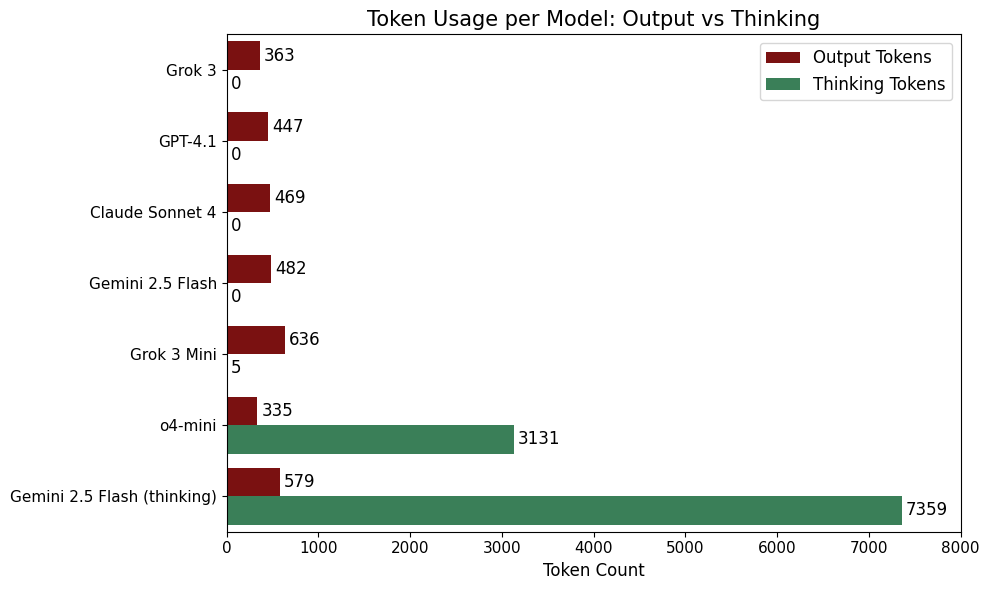

In [25]:
# Round values and reshape
df_long = output_tokens_avg.copy().sort_values(["Avg Thinking Tokens", "Avg Output Tokens"])
df_long["Output Tokens"] = df_long["Avg Output Tokens"].round(0).astype(int)
df_long["Thinking Tokens"] = df_long["Avg Thinking Tokens"].round(0).astype(int)
df_long = df_long[["model", "Output Tokens", "Thinking Tokens"]].melt(
    id_vars="model", var_name="Token Type", value_name="Tokens"
)

# Replace model names with pretty ones
#df_long["model"] = df_long["model"].map(pretty_names)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, y="model", x="Tokens", hue="Token Type", palette=["#8B0000", "#2E8B57"])

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=12)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Token Count", fontsize=12)
plt.ylabel("")
plt.xlim(0,8000)
plt.title("Token Usage per Model: Output vs Thinking", fontsize=15)
plt.legend(title="", fontsize=12)
plt.tight_layout()
#plt.savefig('Figures/tokens_per_model.pdf', bbox_inches='tight')
plt.show()


### Average cost per model

In [26]:
# Define cost per attempt: group by model → mean cost
cost_per_attempt = df.groupby('model')['cost'].mean().reset_index()

# Rename column for clarity
cost_per_attempt.rename(columns={'cost': 'avg cost per attempt ($)'}, inplace=True)

# Optional: add company column
# cost_per_attempt['company'] = cost_per_attempt['model'].str.split('/').str[0]

# Display the table
cost_per_attempt


,model,avg cost per attempt ($)
0,Claude Sonnet 4,0.033088
1,GPT-4.1,0.003604
2,Gemini 2.5 Flash,0.004010
3,Gemini 2.5 Flash (thinking),0.009018
4,Grok 3,0.025645
5,Grok 3 Mini,0.008058
6,o4-mini,0.022918


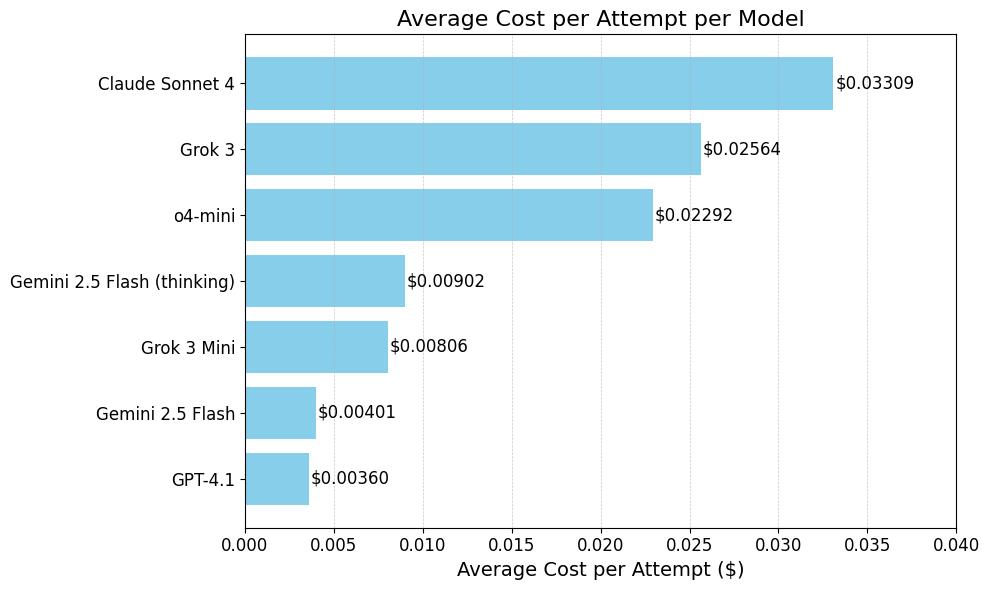

In [27]:
# Sort models by avg cost descending (optional, looks nicer)
cost_per_attempt_sorted = cost_per_attempt.sort_values(by='avg cost per attempt ($)', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    cost_per_attempt_sorted['model'],
    cost_per_attempt_sorted['avg cost per attempt ($)'],
    color='skyblue'
)
plt.xlim(0,0.04)

# Labels and title
plt.xlabel('Average Cost per Attempt ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Cost per Attempt per Model', fontsize=16)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

# Optional: annotate bars with cost value
for i, v in enumerate(cost_per_attempt_sorted['avg cost per attempt ($)']):
    plt.text(v + 0.0001, i, f'${v:.5f}', va='center', fontsize=12)

plt.tight_layout()
#plt.savefig('Figures/cost_per_model.pdf', bbox_inches='tight')
plt.show()

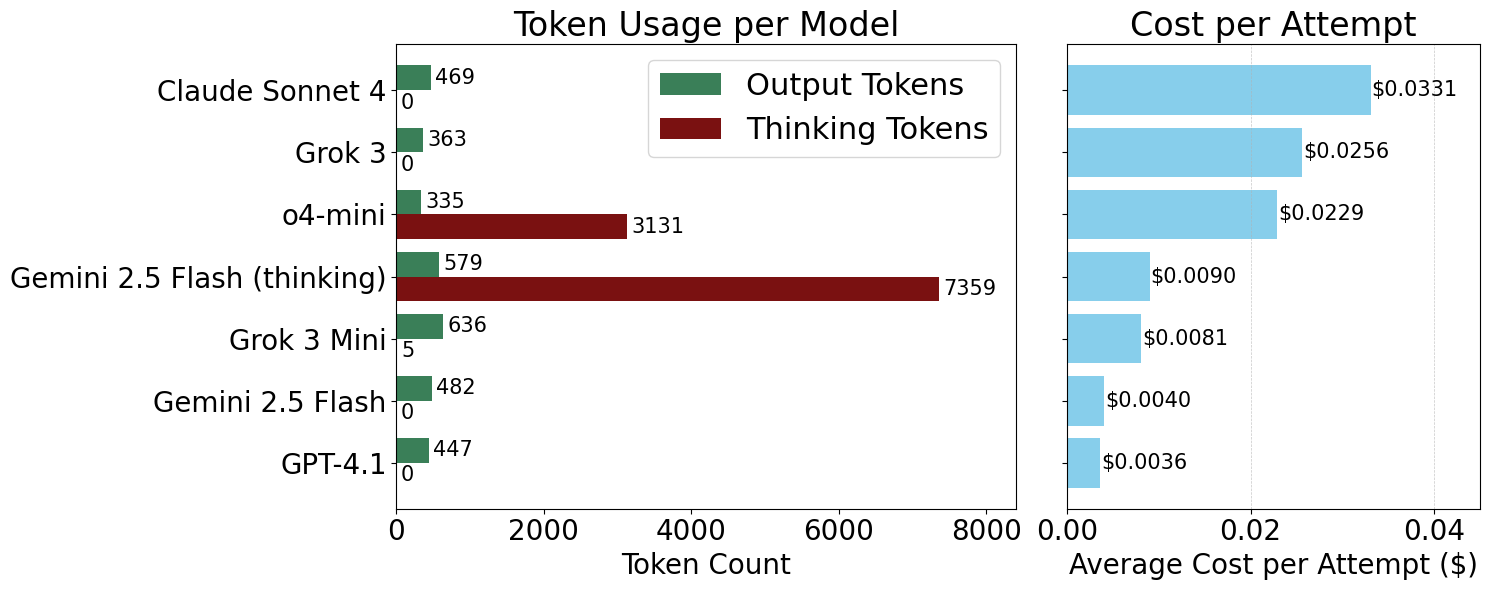

In [28]:
# Prepare token data
df_tokens = output_tokens_avg.copy().sort_values(["Avg Thinking Tokens", "Avg Output Tokens"])
df_tokens["Output Tokens"] = df_tokens["Avg Output Tokens"].round(0).astype(int)
df_tokens["Thinking Tokens"] = df_tokens["Avg Thinking Tokens"].round(0).astype(int)
df_tokens = df_tokens[["model", "Output Tokens", "Thinking Tokens"]].melt(
    id_vars="model", var_name="Token Type", value_name="Tokens"
)

# Get model order from token plot
#model_order = df_tokens["model"].drop_duplicates().tolist()

# Sort models by cost for consistent y-axis
model_order = cost_per_attempt.sort_values('avg cost per attempt ($)', ascending=False)['model'].tolist()

# Apply model order to token data
df_tokens["model"] = pd.Categorical(df_tokens["model"], categories=model_order, ordered=True)
df_tokens = df_tokens.sort_values("model")

# Align cost data using token-based model order
cost_sorted = cost_per_attempt.set_index("model").loc[model_order].reset_index()

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6), sharey=True, gridspec_kw={"width_ratios": [1.5, 1]})

# --- Token Plot ---
sns.barplot(data=df_tokens, y="model", x="Tokens", hue="Token Type", ax=ax1, palette=["#2E8B57", "#8B0000"])
ax1.set_xlabel("Token Count", fontsize=20)
ax1.set_ylabel("")
ax1.set_title("Token Usage per Model", fontsize=24)
ax1.set_xlim(0, 8400)
ax1.tick_params(labelsize=20)
ax1.legend(title="", fontsize=22)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=15)

# --- Cost Plot ---
ax2.barh(
    cost_sorted['model'],
    cost_sorted['avg cost per attempt ($)'],
    color='skyblue'
)
ax2.set_xlabel("Average Cost per Attempt ($)", fontsize=20)
ax2.set_title("Cost per Attempt", fontsize=24)
ax2.set_xlim(0, 0.045)
ax2.tick_params(labelsize=20)
ax2.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
for i, v in enumerate(cost_sorted['avg cost per attempt ($)']):
    ax2.text(v + 0.0001, i, f'${v:.4f}', va='center', fontsize=15)

# Final layout
plt.tight_layout()
plt.savefig('Figures/tokens_and_costs_per_model.pdf', bbox_inches='tight')
plt.show()


### Model cost vs performance

In [29]:
# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Sort by success rate (worst to best)
merged_df = merged_df.sort_values(by='success_rate')

# Display merged_df to check
merged_df


,model,success_rate,avg cost per attempt ($)
6,o4-mini,44.4,0.022918
5,Gemini 2.5 Flash,44.4,0.004010
4,Grok 3 Mini,48.1,0.008058
3,Grok 3,55.6,0.025645
2,Gemini 2.5 Flash (thinking),59.3,0.009018
1,GPT-4.1,63.0,0.003604
0,Claude Sonnet 4,66.7,0.033088


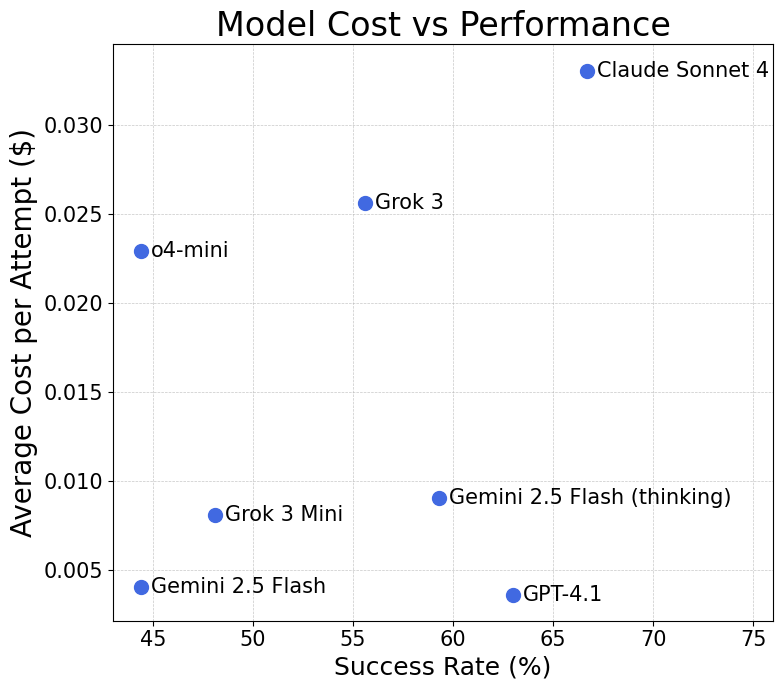

In [30]:
# GIVE THINKING MODELS ORANGE DOTS

# Merge success rate and cost dataframes
merged_df = agg_success_rate[['model', 'success_rate']].merge(
    cost_per_attempt[['model', 'avg cost per attempt ($)']],
    on='model'
)

# Prepare x and y (no jitter)
x_values = merged_df['success_rate']
y_values = merged_df['avg cost per attempt ($)']

# Plot
plt.figure(figsize=(8, 7))
plt.scatter(x_values, y_values, s=100, color='royalblue')

# Add model labels next to points
for i, row in merged_df.iterrows():
    plt.text(
        x_values.iloc[i] + 0.5,  # small offset to right
        y_values.iloc[i],
        row['model'],
        fontsize=15,
        va='center'
    )

# Labels and title
plt.xlabel('Success Rate (%)', fontsize=18)
plt.xlim(43,76)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Average Cost per Attempt ($)', fontsize=20)
plt.title('Model Cost vs Performance', fontsize=24)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('Figures/cost_vs_performance.pdf', bbox_inches='tight')
plt.show()


### Aggregate success@k metrics for each model

In [31]:
# List of (full_run_id, model, exercise, sorted list of success flags per attempt)
run_attempts = df.sort_values(['full_run_id', 'attempt']).groupby('full_run_id').agg({
    'model': 'first',
    'exercise': 'first',
    'success': lambda x: list(x),  # get list of success flags
    'attempt': 'max'  # store max_attempts per run (for correct "not used k" logic)
}).reset_index()

# Determine global max k (max number of attempts used in any run)
max_k = df['max_attempts'].max()

# Compute success@k columns
for k in range(1, max_k + 1):
    def success_at_k(row):
        success_flags = row['success']
        used_attempts = len(success_flags)
        success_in_k = any(success_flags[:k])
        not_used_k = used_attempts < k
        return success_in_k #or not_used_k
    
    run_attempts[f'success@{k}'] = run_attempts.apply(success_at_k, axis=1)

# Now compute per-model success@k mean
successk_cols = [f'success@{k}' for k in range(1, max_k + 1)]
successk_summary = run_attempts.groupby('model')[successk_cols].mean().reset_index()

# Convert to % and round
for col in successk_cols:
    successk_summary[col] = (successk_summary[col] * 100).round(2)

# Optional: rename columns to Success@k (%) style
successk_summary.rename(columns={col: f'Success@{col.split("@")[1]} (%)' for col in successk_cols}, inplace=True)

# Display
successk_summary


,model,Success@1 (%),Success@2 (%),Success@3 (%),Success@4 (%),Success@5 (%),Success@6 (%),Success@7 (%),Success@8 (%),Success@9 (%),...,Success@41 (%),Success@42 (%),Success@43 (%),Success@44 (%),Success@45 (%),Success@46 (%),Success@47 (%),Success@48 (%),Success@49 (%),Success@50 (%)
0,Claude Sonnet 4,14.81,44.44,55.56,62.96,62.96,62.96,62.96,62.96,66.67,...,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67
1,GPT-4.1,11.11,25.93,33.33,40.74,44.44,44.44,44.44,44.44,44.44,...,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96,62.96
2,Gemini 2.5 Flash,14.81,29.63,33.33,37.04,37.04,40.74,40.74,40.74,40.74,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44
3,Gemini 2.5 Flash (thinking),29.63,37.04,44.44,48.15,48.15,55.56,55.56,59.26,59.26,...,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26,59.26
4,Grok 3,25.93,29.63,44.44,44.44,51.85,51.85,51.85,51.85,51.85,...,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56,55.56
5,Grok 3 Mini,18.52,22.22,29.63,37.04,40.74,40.74,40.74,40.74,44.44,...,48.15,48.15,48.15,48.15,48.15,48.15,48.15,48.15,48.15,48.15
6,o4-mini,11.11,25.93,29.63,29.63,33.33,37.04,37.04,40.74,44.44,...,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44,44.44


### Success@k plot

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_successk_summary(successk_summary, run_attempts, k_default_plot=10, show_last_marker=True):
    """
    Plot Success@k CDF curves per model.
    - If a model used <= k_default_plot attempts, plot up to k_default_plot.
    - If a model used > k_default_plot attempts, plot up to its full max_attempts.
    - Optionally show marker on last point only.
    
    Args:
        successk_summary: DataFrame with Success@k (%) columns (like your screenshot)
        run_attempts: DataFrame with per-run info, must include columns ['model', 'attempt']
        k_default_plot: int, default cutoff for low-attempt models (default 10)
        show_last_marker: bool, whether to show a dot on the last point of each line
    """
    # Determine max_attempts per model from run_attempts
    max_attempts_per_model = run_attempts.groupby('model')['attempt'].max().to_dict()

    # Optional: define line styles for variety
    line_styles = ['-', '--', '-.', ':']

    # Plot
    plt.figure(figsize=(12, 5))

    for i, (_, row) in enumerate(successk_summary.iterrows()):
        model_name = row['model']
        model_max_k = max_attempts_per_model.get(model_name, 50)  # fallback to 50 if missing
        
        # Determine which k to plot
        if model_max_k <= k_default_plot:
            k_plot = list(range(1, k_default_plot + 1))
        else:
            k_plot = list(range(1, model_max_k + 1))

        # Extract y values safely
        y = [row.get(f'Success@{k} (%)', None) for k in k_plot]

        # Choose line style
        #linestyle = line_styles[(i + 2) % len(line_styles)]
        linestyle = line_styles[0]

        # Define per-model horizontal offset (small, e.g. ±0.1 or ±0.2)
        # Example: deterministic offset based on model index
        horizontal_offsets = np.linspace(-0.3, 0.3, len(successk_summary))  # spread nicely

        # Inside loop:
        offset = horizontal_offsets[i]  # pick offset for this model

        # Apply offset to x values
        x_shifted = np.array(k_plot) + offset

        # Now plot using x_shifted instead of k_plot
        plt.plot(x_shifted, y, linestyle=linestyle, linewidth=2, label=model_name)

        # Optional: marker on last point → shifted too
        if show_last_marker:
            plt.plot(x_shifted[-1], y[-1], marker='o', markersize=6)


    # Labels and title
    plt.xlabel('k (Number of attempts)', fontsize=20)
    plt.ylabel('Success@k (%)', fontsize=20)
    plt.title(f'Success@k Cumulative Success per Model', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Legend in bottom right
    plt.legend(title='Model', 
               fontsize=18, 
               loc='lower right',
                ncol=2,           # Set to 2 or more to flatten
                columnspacing=1.0,
                handletextpad=0.5)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig('Figures/success_at_k.pdf', bbox_inches='tight')
    plt.show()


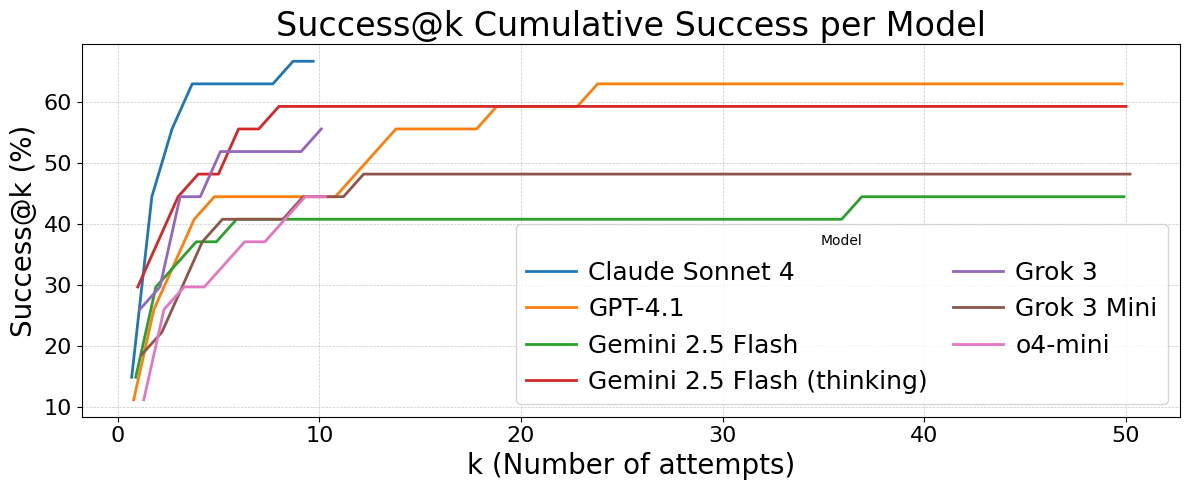

In [33]:
plot_successk_summary(successk_summary, run_attempts, k_default_plot=10, show_last_marker=False)


# Ablations

### Load ablation data

In [34]:
# Define ablation experiment folders
ablation_dirs = {
    "No context definitions": "experiments/ablation_defs_nc",
    "No definitions": "experiments/ablation_no_defs",
    "No hints": "experiments/ablation_no_hints",
    "No tutorial": "experiments/ablation_no_tutorial"
}

# Load each ablation dataset into its own DataFrame
ablation_data = {}

for name, root_dir in ablation_dirs.items():
    data_list = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(subdir, file)
                try:
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    # Extract experiment name
                    experiment_parts = os.path.normpath(subdir).split(os.sep)
                    experiment_idx = experiment_parts.index("experiments") + 1
                    experiment = experiment_parts[experiment_idx]

                    # Extract timestamp (immediate parent folder of the JSON)
                    timestamp = os.path.basename(subdir)

                    # Attach metadata
                    data["experiment"] = experiment
                    data["timestamp"] = timestamp

                    data_list.append(data)

                except json.JSONDecodeError:
                    print(f"Failed to decode JSON: {json_path}")

    df_ablation = pd.DataFrame(data_list)

    # Define full_run_id
    df_ablation['full_run_id'] = df_ablation['experiment'] + ' | ' + df_ablation['timestamp'] + ' | ' + df_ablation['run_id']

    # Store
    ablation_data[name] = df_ablation


In [35]:
# Mapping for clean model names
pretty_names = {
    "anthropic/claude-sonnet-4": "Claude Sonnet 4",
    "google/gemini-2.5-flash-preview-05-20": "Gemini 2.5 Flash",
    "openai/gpt-4.1": "GPT-4.1",
    "x-ai/grok-3-beta": "Grok 3",
    "x-ai/grok-3-mini-beta": "Grok 3 Mini",
    "openai/o4-mini": "o4-mini",
    "google/gemini-2.5-flash-preview-05-20:thinking": "Gemini 2.5 Flash (thinking)",
}

for name in ablation_data:
    ablation_data[name]["model"] = ablation_data[name]["model"].map(pretty_names)

### Display incomplete runs (check that all runs are complete)

In [36]:
for name in ablation_data:
    incomplete_df = find_incomplete_runs(ablation_data[name])
    if not incomplete_df.empty:
        print(incomplete_df.to_string(index=False))


### Get corresponding baseline data from the main dataset

In [37]:
models_of_interest = [
    "Claude Sonnet 4",
    "Gemini 2.5 Flash (thinking)",
    "GPT-4.1"
]

ablation_exercises = {
    "No definitions": [
        "10_7_intermediate", "4_9_1", "4_9_3", "5_9_1", "13_11_3"
    ],
    "No context definitions": [
        "10_7_intermediate", "4_9_1", "4_9_3", "5_9_1", "13_11_3"
    ],
    "No hints": [
    "2_non_degenerate_1", "2_non_degenerate_2",
    "2_positive_1", "2_positive_2",
    "2_reflexive_1", "2_reflexive_2",
    "2_symmetric_1", "2_symmetric_2",
    "2_triangle_inequality_1", "2_triangle_inequality_2",
    "3_11_1", "3_11_2", "3_11_4",
    "4_9_1", "4_9_2", "4_9_3",
    "5_9_1", "5_9_2",
    "6_8_1", "6_8_2",
    "10_7_3",
    "10_7_6", "10_7_intermediate",
    "11_not_closed", "11_not_open",
    "13_11_2", "13_11_3"
    ],
    "No tutorial": [
        "2_non_degenerate_2", "2_positive_1", "2_positive_2",
        "2_reflexive_1", "2_reflexive_2", "3_11_1"
    ]
}

baseline_data = {
    name: df[
        (df['model'].isin(models_of_interest)) &
        (df['exercise'].isin(exercises))
    ].copy()
    for name, exercises in ablation_exercises.items()
}

mapped = [label_mapping.get(x, x) for x in ablation_exercises["No definitions"]]
mapped

['10.7.3i', '4.9.1', '4.9.3', '5.9.1', '13.11.3']

### Calculate side-by-side success rates per ablation

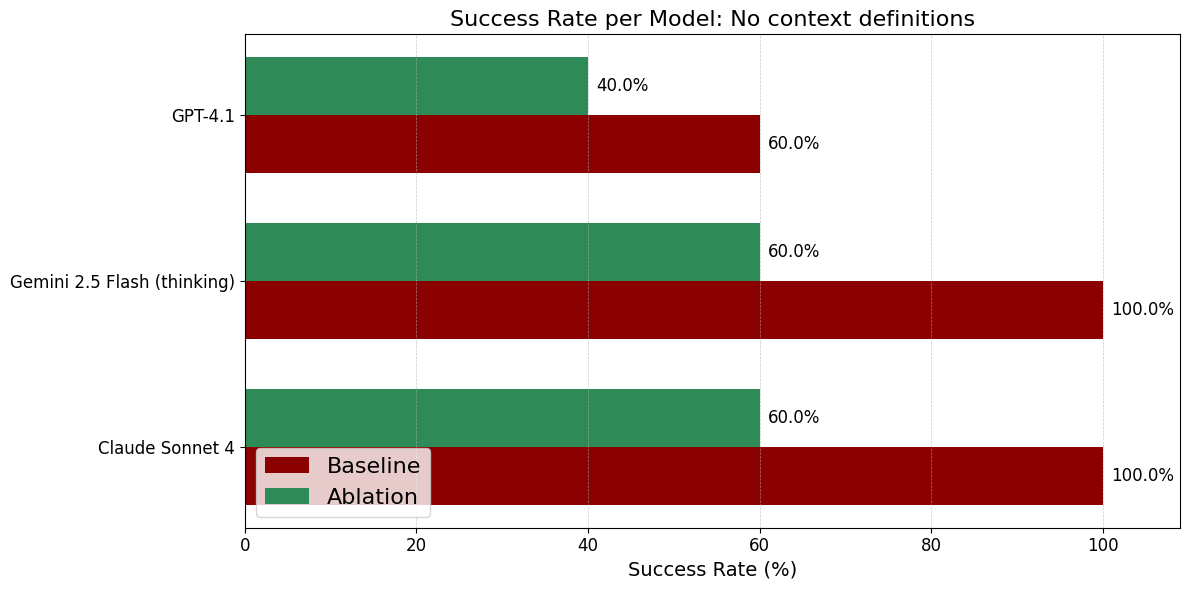


Success Rate Comparison for No context definitions:



,model,Baseline,Ablation
0,Claude Sonnet 4,100.0,60.0
2,Gemini 2.5 Flash (thinking),100.0,60.0
1,GPT-4.1,60.0,40.0



Model: Claude Sonnet 4
  Solved in baseline but not in ablation:
    13_11_3, 4_9_3
  Solved in ablation but not in baseline:
    None

Model: Gemini 2.5 Flash (thinking)
  Solved in baseline but not in ablation:
    13_11_3, 4_9_3
  Solved in ablation but not in baseline:
    None

Model: GPT-4.1
  Solved in baseline but not in ablation:
    4_9_1
  Solved in ablation but not in baseline:
    None


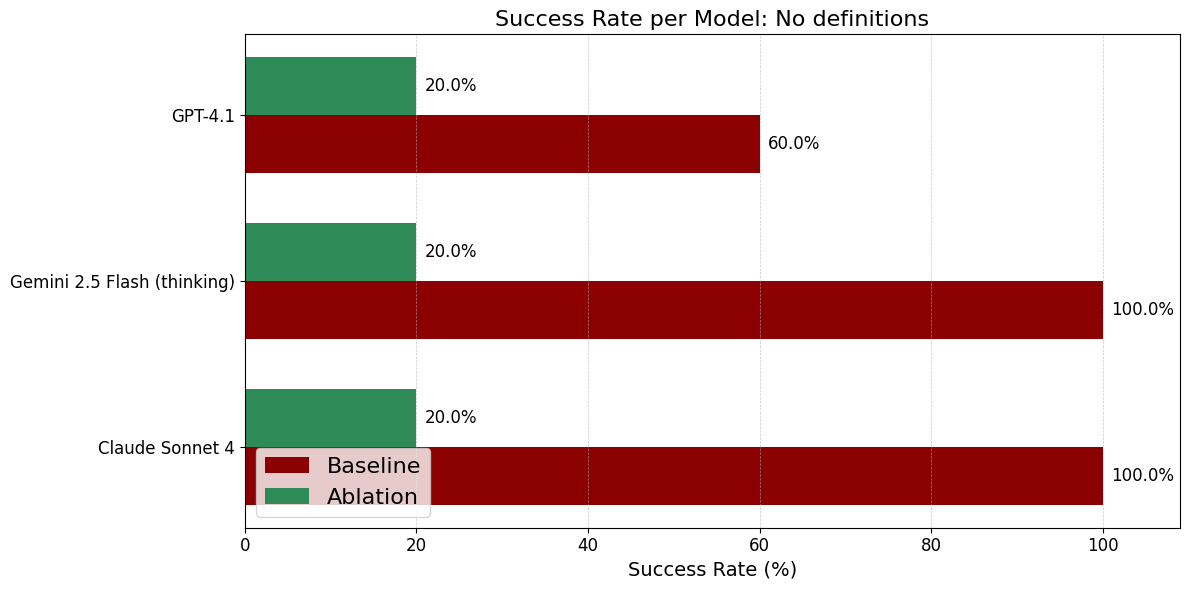


Success Rate Comparison for No definitions:



,model,Baseline,Ablation
0,Claude Sonnet 4,100.0,20.0
2,Gemini 2.5 Flash (thinking),100.0,20.0
1,GPT-4.1,60.0,20.0



Model: Claude Sonnet 4
  Solved in baseline but not in ablation:
    13_11_3, 4_9_1, 4_9_3, 5_9_1
  Solved in ablation but not in baseline:
    None

Model: Gemini 2.5 Flash (thinking)
  Solved in baseline but not in ablation:
    13_11_3, 4_9_1, 4_9_3, 5_9_1
  Solved in ablation but not in baseline:
    None

Model: GPT-4.1
  Solved in baseline but not in ablation:
    4_9_1, 5_9_1
  Solved in ablation but not in baseline:
    None


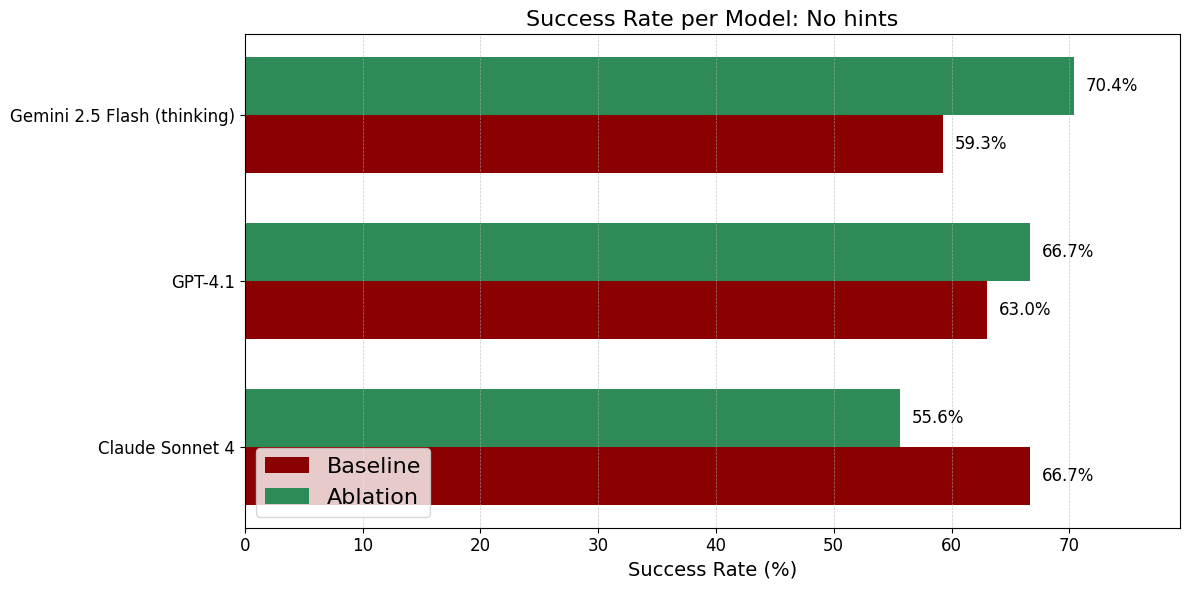


Success Rate Comparison for No hints:



,model,Baseline,Ablation
0,Claude Sonnet 4,66.7,55.6
1,GPT-4.1,63.0,66.7
2,Gemini 2.5 Flash (thinking),59.3,70.4



Model: Claude Sonnet 4
  Solved in baseline but not in ablation:
    13_11_3, 4_9_3, 6_8_1
  Solved in ablation but not in baseline:
    None

Model: GPT-4.1
  Solved in baseline but not in ablation:
    3_11_4
  Solved in ablation but not in baseline:
    10_7_3, 4_9_3

Model: Gemini 2.5 Flash (thinking)
  Solved in baseline but not in ablation:
    None
  Solved in ablation but not in baseline:
    2_non_degenerate_1, 2_triangle_inequality_2, 6_8_1


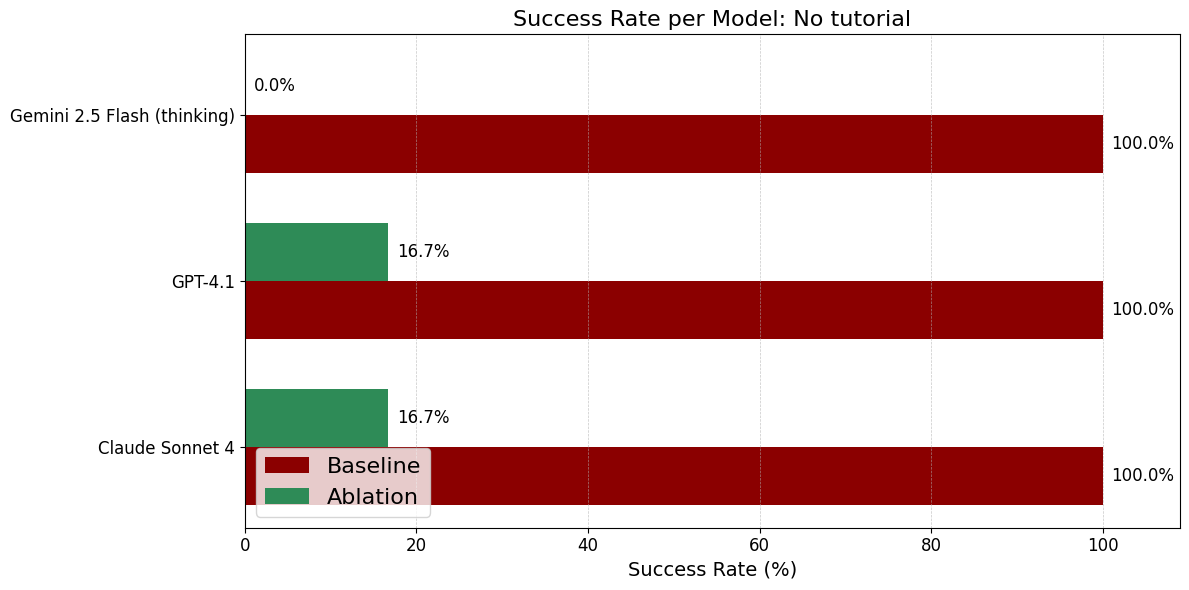


Success Rate Comparison for No tutorial:



,model,Baseline,Ablation
0,Claude Sonnet 4,100.0,16.7
1,GPT-4.1,100.0,16.7
2,Gemini 2.5 Flash (thinking),100.0,0.0



Model: Claude Sonnet 4
  Solved in baseline but not in ablation:
    2_non_degenerate_2, 2_positive_2, 2_reflexive_1, 2_reflexive_2, 3_11_1
  Solved in ablation but not in baseline:
    None

Model: GPT-4.1
  Solved in baseline but not in ablation:
    2_non_degenerate_2, 2_positive_1, 2_positive_2, 2_reflexive_2, 3_11_1
  Solved in ablation but not in baseline:
    None

Model: Gemini 2.5 Flash (thinking)
  Solved in baseline but not in ablation:
    2_non_degenerate_2, 2_positive_1, 2_positive_2, 2_reflexive_1, 2_reflexive_2, 3_11_1
  Solved in ablation but not in baseline:
    None


In [38]:
def compute_success_rates(df_input):
    per_run_success = df_input.groupby(['model', 'full_run_id'])['success'].max().reset_index()
    agg = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()
    agg.rename(columns={
        'mean': 'success_rate',
        'count': 'total_runs',
        'sum': 'successful_runs'
    }, inplace=True)
    agg['success_rate'] = (agg['success_rate'] * 100).round(1)
    return agg[['model', 'success_rate']]

for name in ablation_data:
    df_ablation = ablation_data[name]
    df_baseline = baseline_data[name]

    # Compute success rates
    sr_ablation = compute_success_rates(df_ablation).rename(columns={'success_rate': 'Ablation'})
    sr_baseline = compute_success_rates(df_baseline).rename(columns={'success_rate': 'Baseline'})

    # Merge and sort
    comparison = pd.merge(sr_baseline, sr_ablation, on='model', how='inner')
    comparison = comparison.sort_values(by='Baseline', ascending=False)

    # === Bar Plot ===
    models = comparison['model']
    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.barh(x - width/2, comparison['Baseline'], height=width, label='Baseline', color='darkred')
    plt.barh(x + width/2, comparison['Ablation'], height=width, label='Ablation', color='seagreen')

    plt.yticks(x, models, fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Success Rate (%)', fontsize=14)
    plt.title(f'Success Rate per Model: {name}', fontsize=16)
    plt.xlim(0, max(comparison[['Baseline', 'Ablation']].max()) + 9)
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower left', fontsize=16)

    for i in range(len(models)):
        plt.text(comparison['Baseline'].iloc[i] + 1, x[i] - width/2, f"{comparison['Baseline'].iloc[i]:.1f}%", va='center', fontsize=12)
        plt.text(comparison['Ablation'].iloc[i] + 1, x[i] + width/2, f"{comparison['Ablation'].iloc[i]:.1f}%", va='center', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'Figures/success_rate_{name}.pdf', bbox_inches='tight')
    plt.show()

    # Display table
    display_name = name.replace('df_', '')
    print(f"\nSuccess Rate Comparison for {display_name}:\n")
    display(comparison)

    # === Print gained/lost exercises per model ===
    for model in comparison['model']:
        # Sets of solved exercises
        solved_baseline = set(df_baseline[(df_baseline['model'] == model) & (df_baseline['success'])]['exercise'])
        solved_ablation = set(df_ablation[(df_ablation['model'] == model) & (df_ablation['success'])]['exercise'])

        lost = sorted(solved_baseline - solved_ablation)
        gained = sorted(solved_ablation - solved_baseline)

        print(f"\nModel: {model}")
        print("  Solved in baseline but not in ablation:")
        print("   ", ", ".join(lost) if lost else "None")
        print("  Solved in ablation but not in baseline:")
        print("   ", ", ".join(gained) if gained else "None")


### Success@k metrics for ablations vs baseline

In [39]:
def compute_successk_components(df_input, max_k=None):
    run_attempts = df_input.sort_values(['full_run_id', 'attempt']).groupby('full_run_id').agg({
        'model': 'first',
        'exercise': 'first',
        'success': lambda x: list(x),
        'attempt': 'max'
    }).reset_index()

    if max_k is None:
        max_k = df_input['max_attempts'].max()

    for k in range(1, max_k + 1):
        run_attempts[f'success@{k}'] = run_attempts['success'].apply(lambda flags: any(flags[:k]))

    return run_attempts, max_k


In [40]:
def plot_multi_successk_comparison_mixed_k(run_attempts_dict, max_k_dict, ablation_name=None):
    import matplotlib.pyplot as plt
    import numpy as np

    models = list(next(iter(run_attempts_dict.values()))['model'].unique())
    num_models = len(models)

    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(6 * num_models, 6), sharey=True)

    if num_models == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        max_k = max_k_dict.get(model, 50)
        k_range = np.arange(1, max_k + 1)

        for label, df in run_attempts_dict.items():
            filtered = df[df['model'] == model]
            means = filtered[[f'success@{k}' for k in k_range]].mean() * 100
            linestyle = '-' if label == 'Baseline' else '--'
            ax.plot(k_range, means, label=label, linestyle=linestyle, linewidth=2)

        ax.set_title(model, fontsize=28)
        ax.set_xlabel('k (Attempts)', fontsize=20)
        ax.tick_params(axis='both', labelsize=20)
        ax.grid(True, linestyle='--', alpha=0.6)

        if ax is axes[0]:
            ax.set_ylabel('Success@k (%)', fontsize=28)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=22, ncol=len(run_attempts_dict))

    title = "Success@k per Model"
    if ablation_name:
        title += f" – Ablation: {ablation_name}"
    fig.suptitle(title, fontsize=32)

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])

    filename = f'Figures/success_at_k_combined_mixed_{ablation_name.replace(" ", "_")}.pdf'
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


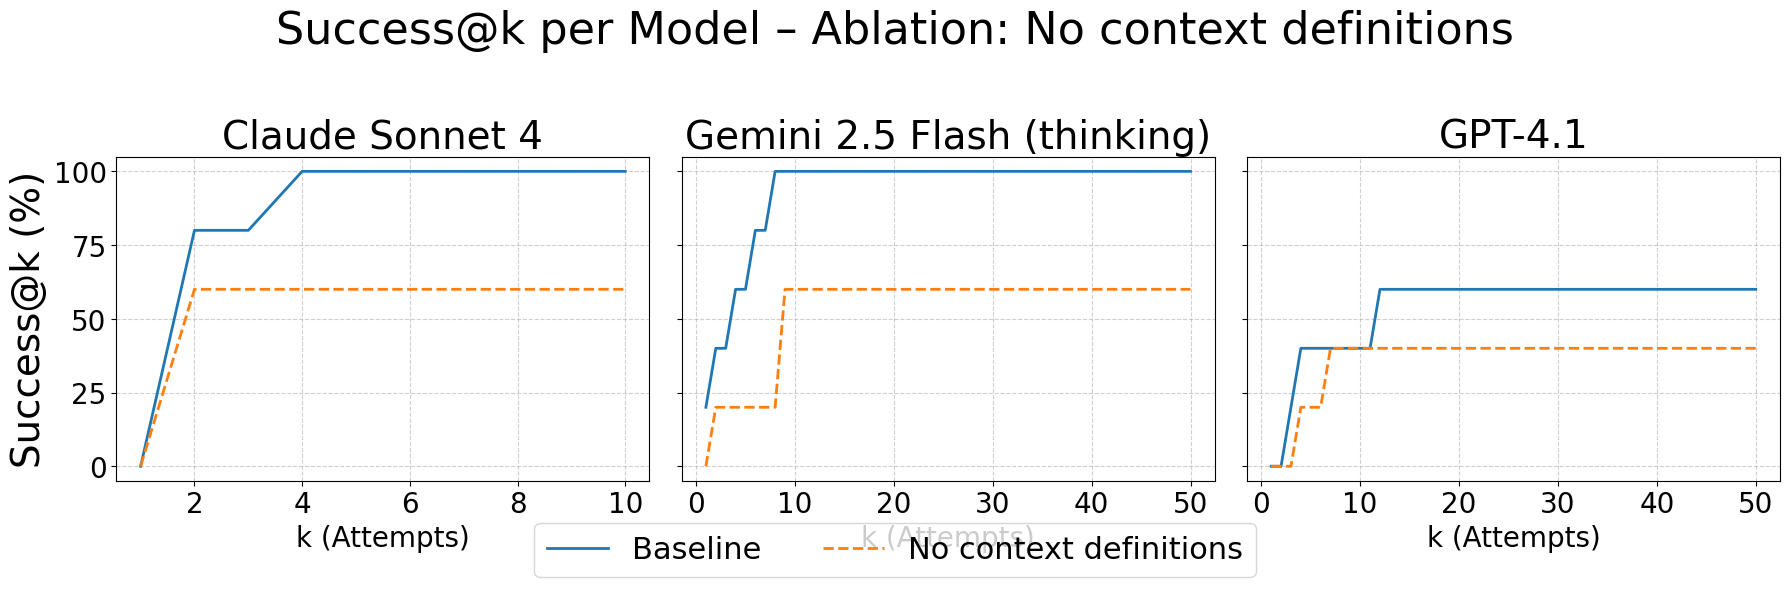

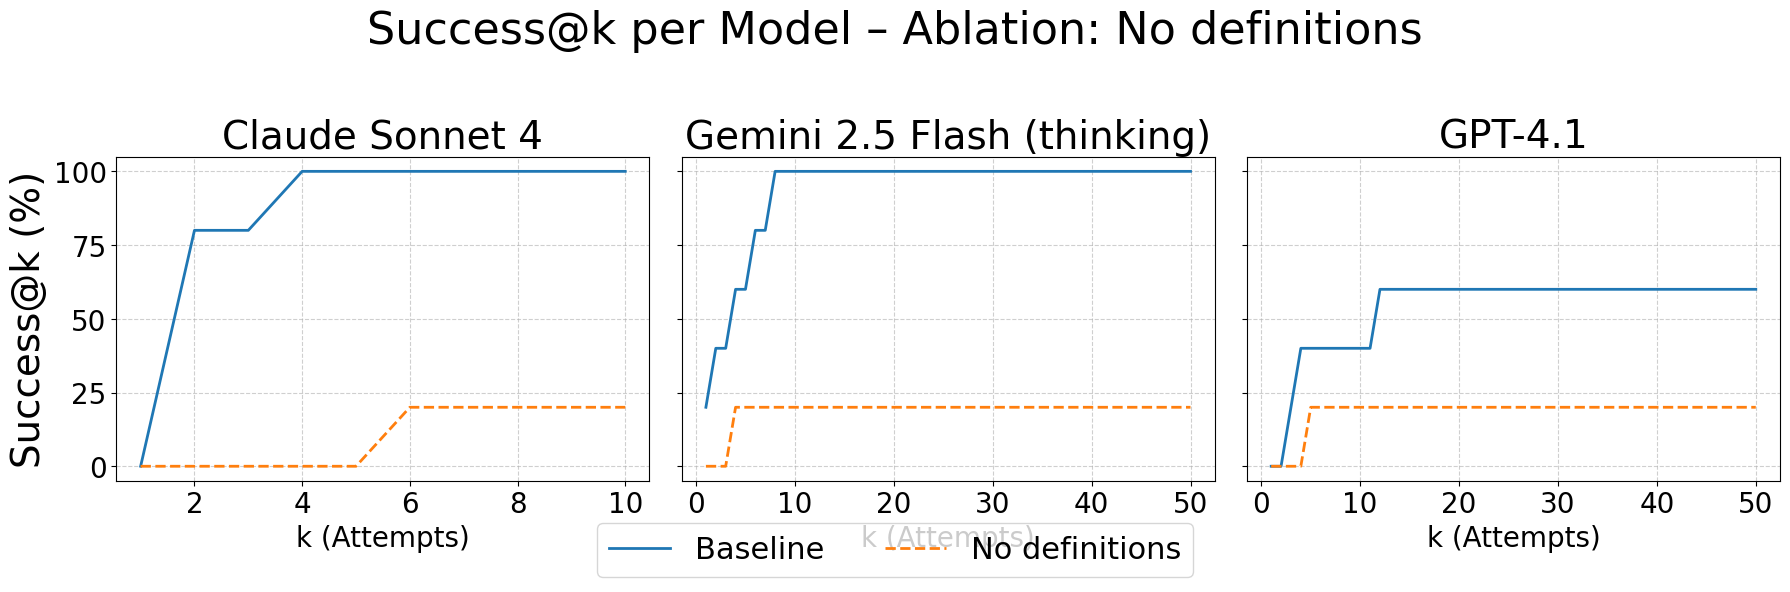

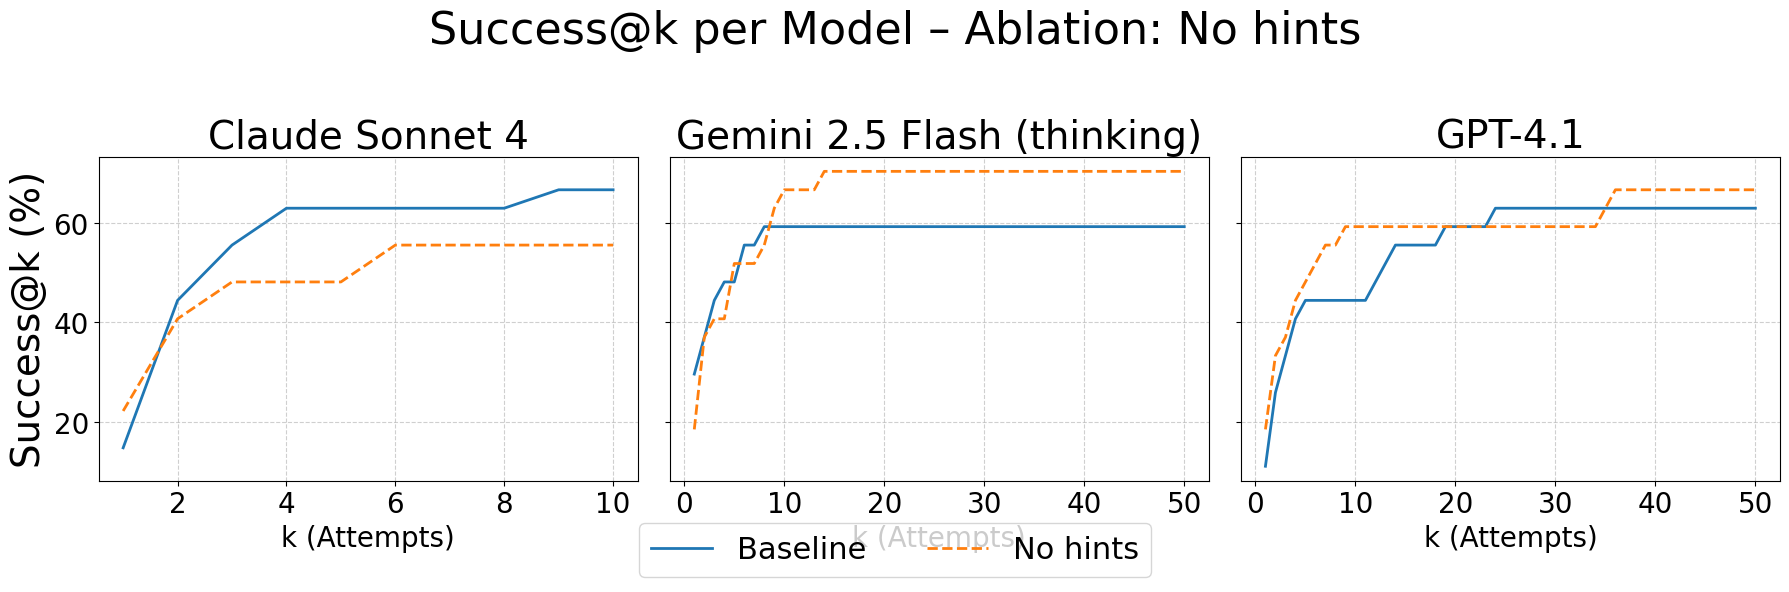

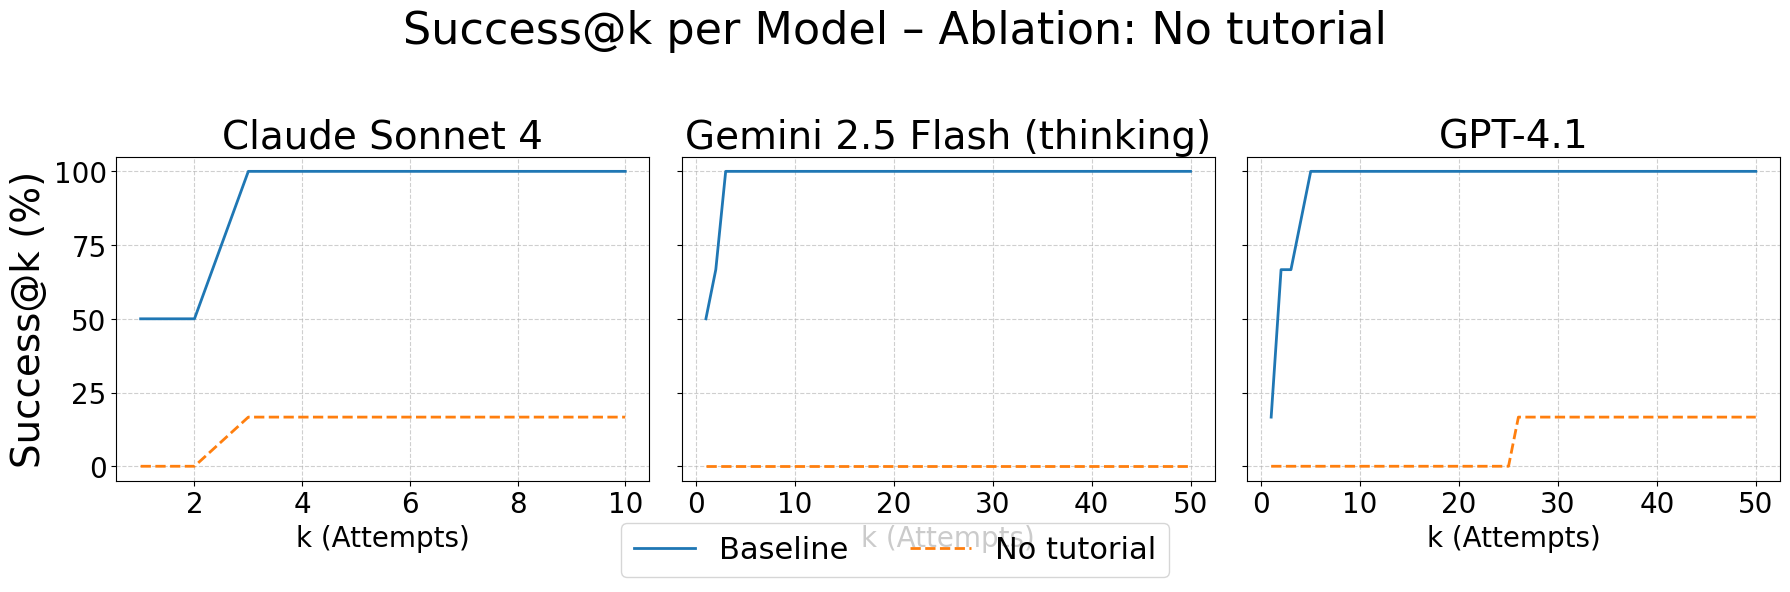

In [41]:
# All ablations you want to visualize
selected_ablation_names = list(ablation_data.keys())

# Loop over ablations
for ablation_name in selected_ablation_names:
    abla_df = ablation_data[ablation_name]
    baseline_df = baseline_data[ablation_name]

    # Compute success@k for both
    abla_attempts, _ = compute_successk_components(abla_df, max_k=50)
    base_attempts, _ = compute_successk_components(baseline_df, max_k=50)

    # Combine into dict
    run_attempts_dict = {
        'Baseline': base_attempts,
        ablation_name: abla_attempts
    }

    # Extract model list and define per-model max_k
    models = base_attempts['model'].unique()
    max_k_dict = {
        model: 10 if model == "Claude Sonnet 4" else 50
        for model in models
    }

    # Filter all to relevant models only
    filtered_run_attempts_dict = {
        label: df[df['model'].isin(models)]
        for label, df in run_attempts_dict.items()
    }

    # Plot
    plot_multi_successk_comparison_mixed_k(
        filtered_run_attempts_dict,
        max_k_dict=max_k_dict,
        ablation_name=ablation_name
    )


In [43]:
def plot_multi_successk_comparison_dict_mixed_k(run_attempts_dict, max_k_dict, ablation_name=None):
    import matplotlib.pyplot as plt
    import numpy as np

    models = list(next(iter(run_attempts_dict.values()))['model'].unique())
    num_models = len(models)

    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(6 * num_models, 6), sharey=True)

    if num_models == 1:
        axes = [axes]

    # Define a list of line styles to rotate through for non-baseline lines
    alt_linestyles = ['--', '-.', ':']
    style_map = {}
    style_idx = 0

    for ax, model in zip(axes, models):
        max_k = max_k_dict.get(model, 50)  # fallback if not explicitly given
        k_range = np.arange(1, max_k + 1)

        for label, df in run_attempts_dict.items():
            filtered = df[df['model'] == model]
            means = filtered[[f'success@{k}' for k in k_range]].mean() * 100
            
            if label.lower() == 'baseline':
                linestyle = '-'  # baseline always solid
            else:
                # assign or reuse a line style from the rotating list
                if label not in style_map:
                    style_map[label] = alt_linestyles[style_idx % len(alt_linestyles)]
                    style_idx += 1
                linestyle = style_map[label]

            ax.plot(k_range, means, label=label, linestyle=linestyle, linewidth=2)

        ax.set_title(model, fontsize=28)
        ax.set_xlabel('k (Attempts)', fontsize=20)
        ax.tick_params(axis='both', labelsize=20)
        ax.grid(True, linestyle='--', alpha=0.6)

        if ax is axes[0]:
            ax.set_ylabel('Success@k (%)', fontsize=28)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=22, ncol=len(run_attempts_dict))

    title = "Success@k per Model"
    if ablation_name:
        title += f" – Ablation: {ablation_name}"
    fig.suptitle(title, fontsize=32)

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])

    filename = f'Figures/success_at_k_combined_mixed_{ablation_name.replace(" ", "_")}.pdf'
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


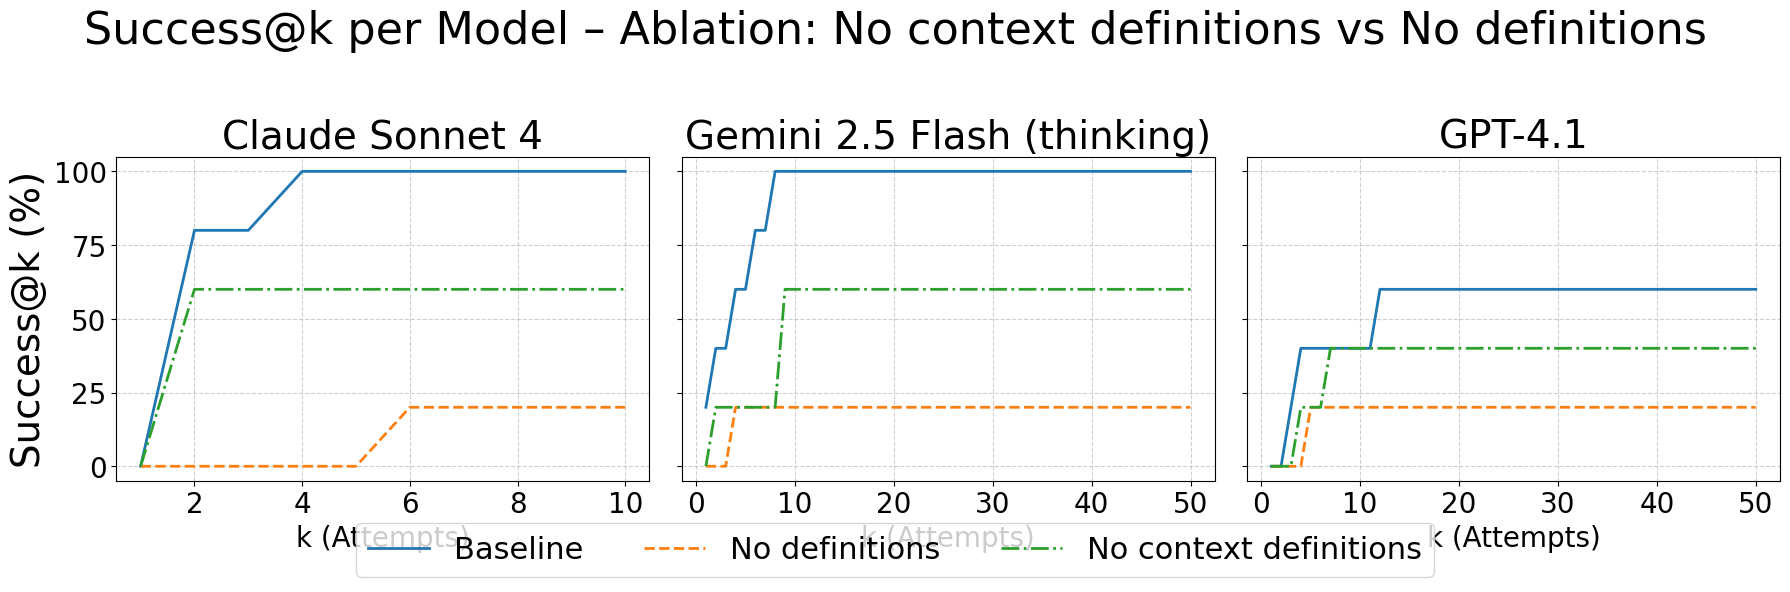

In [44]:
selected_ablation_names = ['No definitions', 'No context definitions']

# Load everything at max_k=50 so all success@k cols exist
full_run_attempts_dict = {}
for label in ['Baseline'] + selected_ablation_names:
    df_data = baseline_data['No definitions'] if label == 'Baseline' else ablation_data[label]
    attempts, _ = compute_successk_components(df_data, max_k=50)
    full_run_attempts_dict[label] = attempts

# Determine models and set per-model max_k
models = next(iter(full_run_attempts_dict.values()))['model'].unique()
max_k_dict = {
    model: 10 if model == "Claude Sonnet 4" else 50
    for model in models
}

# Filter only relevant models from each df
filtered_run_attempts_dict = {
    label: df_data[df_data['model'].isin(max_k_dict.keys())]
    for label, df_data in full_run_attempts_dict.items()
}

# Plot with mixed x-axis ranges
plot_multi_successk_comparison_dict_mixed_k(
    filtered_run_attempts_dict,
    max_k_dict=max_k_dict,
    ablation_name="No context definitions vs No definitions"
)


### Inspect ablation runs

In [45]:
models_of_interest = [
    "Claude Sonnet 4",
    "Gemini 2.5 Flash (thinking)",
    "GPT-4.1"
]

model_to_inspect = "Gemini 2.5 Flash (thinking)" # choose model here

data = ablation_data['No tutorial'] # choose ablation here
df_model = data[data['model'] == model_to_inspect].copy()

unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")

Number of unique runs for model 'Gemini 2.5 Flash (thinking)': 6
0: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::2_reflexive_2::1
1: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::2_positive_1::1
2: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::3_11_1::1
3: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::2_reflexive_1::1
4: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::2_positive_2::1
5: ablation_no_tutorial | 2025-06-18_21-34-52 | google/gemini-2.5-flash-preview-05-20:thinking::2_non_degenerate_2::1


In [46]:
run_index = 0 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]

,model,exercise,attempt,error_message,line_with_error
310,Gemini 2.5 Flash (thinking),2_reflexive_2,1,Error:\nSyntax error: [ltac_use_default] expected after [ltac2_expr] (in [ltac2_command]).\n\n,assume a in R.
322,Gemini 2.5 Flash (thinking),2_reflexive_2,2,Error: Syntax error: illegal begin of vernac.\n\n,fix a.
279,Gemini 2.5 Flash (thinking),2_reflexive_2,3,Error:\nSyntax error: [ltac_use_default] expected after [ltac2_expr] (in [ltac2_command]).\n\n,"show d(a, a) = 0 by definition d_discrete_R."
340,Gemini 2.5 Flash (thinking),2_reflexive_2,4,Error:\nSyntax error: [ltac_use_default] expected after [ltac2_expr] (in [ltac2_command]).\n\n,"show d(a, a) = 0 by simpl."
300,Gemini 2.5 Flash (thinking),2_reflexive_2,5,Error: (in proof d_reflexive): Attempt to save an incomplete proof\n\n,Qed.
368,Gemini 2.5 Flash (thinking),2_reflexive_2,6,"Error: In environment\na : (@subset_type)(ℝ, (∈ ℝ)%pfs)\nH : a ∈ ℝ\nUnable to unify ""0"" with ""d(...",reflexivity.
335,Gemini 2.5 Flash (thinking),2_reflexive_2,7,Error:\nSyntax error: ')' or ':' expected after [ltac2_expr] (in [ltac2_expr]).\n\n,replace (a = a) with true.
307,Gemini 2.5 Flash (thinking),2_reflexive_2,8,"Error: In environment\na : (@subset_type)(ℝ, (∈ ℝ)%pfs)\nH : a ∈ ℝ\nUnable to unify ""0"" with ""if...",reflexivity.
346,Gemini 2.5 Flash (thinking),2_reflexive_2,9,Error: Expected a single focused goal but 2 goals are focused.\n\n,simpl. (* This simplifies the if-then-else based on the boolean condition. *)
277,Gemini 2.5 Flash (thinking),2_reflexive_2,10,"Error: In environment\na : (@subset_type)(ℝ, (∈ ℝ)%pfs)\nx : True\nUnable to unify ""R0"" with\n ""...",reflexivity.


In [47]:
show_proof_diff(df_run, 1, 2)

# Natural language experiment

### Load data

In [48]:
# Natural language experiment root
nl_root_dir = "experiments/natural_language_defs_context"

# Prepare a list for the data
data_list_nl = []

# Walk through the directory tree
for subdir, _, files in os.walk(nl_root_dir):
    for file in files:
        if file.endswith('.json'):
            json_path = os.path.join(subdir, file)
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Extract experiment name
                experiment_name = os.path.normpath(subdir).split(os.sep)
                experiment_idx = experiment_name.index("experiments") + 1
                experiment = experiment_name[experiment_idx]

                # Extract timestamp
                timestamp = os.path.basename(subdir)

                # Add metadata
                data["experiment"] = experiment
                data["timestamp"] = timestamp
                data_list_nl.append(data)

            except json.JSONDecodeError:
                print(f"Failed to decode JSON: {json_path}")

# Create DataFrame
df_nl_defs = pd.DataFrame(data_list_nl)

# Define composite run ID
df_nl_defs['full_run_id'] = df_nl_defs['experiment'] + ' | ' + df_nl_defs['timestamp'] + ' | ' + df_nl_defs['run_id']

# You can now inspect or compare df_nl_defs separately
len(df_nl_defs)

159

In [49]:
# Mapping for clean model names
pretty_names = {
    "anthropic/claude-sonnet-4": "Claude Sonnet 4",
    "google/gemini-2.5-flash-preview-05-20": "Gemini 2.5 Flash",
    "openai/gpt-4.1": "GPT-4.1",
    "x-ai/grok-3-beta": "Grok 3",
    "x-ai/grok-3-mini-beta": "Grok 3 Mini",
    "openai/o4-mini": "o4-mini",
    "google/gemini-2.5-flash-preview-05-20:thinking": "Gemini 2.5 Flash (thinking)",
}

df_nl_defs["model"] = df_nl_defs["model"].map(pretty_names)

In [50]:
# 1. Get models and exercises used in the NL experiment
nl_models = df_nl_defs['model'].unique()
nl_exercises = df_nl_defs['exercise'].unique()

# 2. Keep only rows from df where:
#    model is in NL experiment AND exercise is NOT in NL experiment
df_base_subset = df[
    (df['model'].isin(nl_models)) &
    (~df['exercise'].isin(nl_exercises))
]

# 3. Combine with NL experiment data
df_nl = pd.concat([df_base_subset, df_nl_defs], ignore_index=True)

### See number of runs per model

In [59]:
# Count number of unique runs per model
runs_per_model_nl = df_nl[['model', 'full_run_id']].drop_duplicates().groupby('model').size().reset_index(name='num_runs')

# Optional: sort by num_runs descending
runs_per_model_nl = runs_per_model_nl.sort_values(by='num_runs', ascending=False)

# Display
runs_per_model_nl

,model,num_runs
0,Claude Sonnet 4,27
1,Gemini 2.5 Flash (thinking),27


### Inspect runs per model

In [74]:
models_of_interest = [
    "Claude Sonnet 4",
    "Gemini 2.5 Flash (thinking)"
]

model_to_inspect = "Claude Sonnet 4"

# Filter to the model of interest
df_model = df_nl[df_nl['model'] == model_to_inspect].copy()

# Get unique runs
unique_full_run_ids = df_model['full_run_id'].unique()

print(f"Number of unique runs for model '{model_to_inspect}': {len(unique_full_run_ids)}")

# Optionally show the run IDs for inspection
for i, run in enumerate(unique_full_run_ids):
    print(f"{i}: {run}")

Number of unique runs for model 'Claude Sonnet 4': 27
0: fixing_exercises | 2025-06-15_00-25-19 | anthropic/claude-sonnet-4::5_9_1::1
1: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_reflexive_2::1
2: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_positive_2::1
3: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_reflexive_1::1
4: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_symmetric_2::1
5: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_positive_1::1
6: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_symmetric_1::1
7: fixing_exercises | 2025-06-15_00-39-44 | anthropic/claude-sonnet-4::2_triangle_inequality_1::1
8: fixing_exercises | 2025-06-14_23-39-11 | anthropic/claude-sonnet-4::2_non_degenerate_1::1
9: fixing_exercises | 2025-06-15_00-02-04 | anthropic/claude-sonnet-4::2_non_degenerate_2::1
10: some_models_all_ex_defs_context | 2025-06-10_03-09-2

In [75]:
run_index = 24 # change this to pick different run
selected_full_run_id = unique_full_run_ids[run_index]

df_run = df_model[df_model['full_run_id'] == selected_full_run_id].sort_values(by='attempt').copy()

df_run['error_message'] = df_run['errors'].apply(
    lambda x: x.split('\n', 1)[1] if isinstance(x, str) and '\n' in x else ''
)

df_run[['model', 'exercise', 'attempt', 'error_message', 'line_with_error']]

,model,exercise,attempt,error_message,line_with_error
275,Claude Sonnet 4,6_8_2,1,"Error: Syntax error: ',' or 'in' '(' expected (in [ltac2_expr]).\n\n",Use M := (-M) in the assumption.
309,Claude Sonnet 4,6_8_2,2,Error: `Use ... in (*)` only works if (*) starts with a for-all quantifier.\n\n,Use M := (-M) in (i).
200,Claude Sonnet 4,6_8_2,3,"Warning: Expected variable name N2 instead of N1.\nFile ""/tmp/E6_8_2_ue8b45il.v"", line 61, chara...",Choose N1 := N1.
218,Claude Sonnet 4,6_8_2,4,,None


In [76]:
show_proof_diff(df_run, 1, 2)

### Success rates per model

In [55]:
def compute_success_rates(df_input):
    per_run_success = df_input.groupby(['model', 'full_run_id'])['success'].max().reset_index()
    agg = per_run_success.groupby('model')['success'].agg(['mean', 'count', 'sum']).reset_index()
    agg.rename(columns={
        'mean': 'success_rate',
        'count': 'total_runs',
        'sum': 'successful_runs'
    }, inplace=True)
    agg['success_rate'] = (agg['success_rate'] * 100).round(1)
    return agg[['model', 'success_rate']]


In [56]:
success_df = compute_success_rates(df)
success_nl = compute_success_rates(df_nl)

# Rename for clarity
success_df.rename(columns={'success_rate': 'Without strategizing'}, inplace=True)
success_nl.rename(columns={'success_rate': 'With strategizing'}, inplace=True)

In [57]:
# Merge on model
comparison = pd.merge(success_df, success_nl, on='model', how='inner')

# Optional: sort by 'With NL' descending
comparison = comparison.sort_values(by='With strategizing', ascending=False)

comparison


,model,Without strategizing,With strategizing
0,Claude Sonnet 4,66.7,77.8
1,Gemini 2.5 Flash (thinking),59.3,70.4


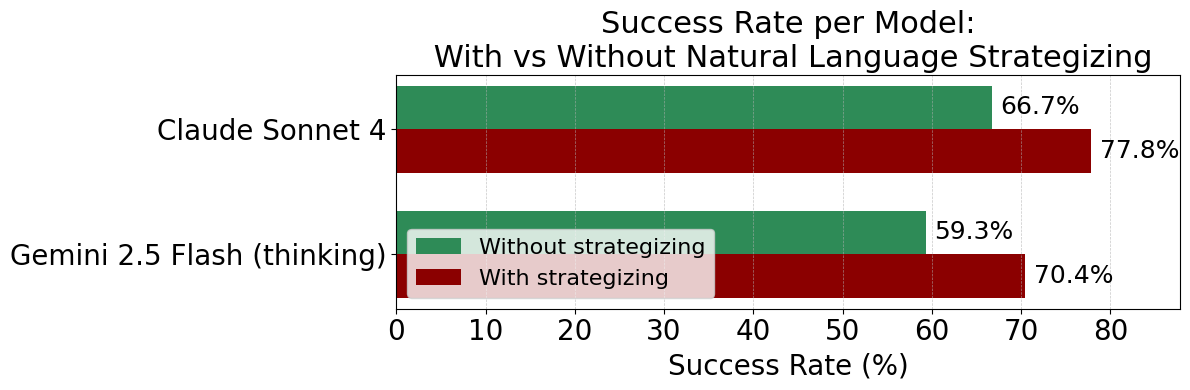

In [58]:
# Data for plotting
models = comparison['model']
x = np.arange(len(models))  # model positions
width = 0.35  # bar width

# Plot
plt.figure(figsize=(12, 4))

plt.barh(x - width/2, comparison['Without strategizing'], height=width, label='Without strategizing', color='seagreen')
plt.barh(x + width/2, comparison['With strategizing'], height=width, label='With strategizing', color='darkred')

plt.gca().invert_yaxis()

# Axis setup
plt.yticks(x, models, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Success Rate (%)', fontsize=20)
plt.title('Success Rate per Model:\n With vs Without Natural Language Strategizing', fontsize=22)
plt.xlim(0, max(comparison[['With strategizing', 'Without strategizing']].max()) + 10)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='lower left', fontsize=16)

# Annotate bars
for i in range(len(models)):
    plt.text(comparison['Without strategizing'].iloc[i] + 1, x[i] - width/2, f"{comparison['Without strategizing'].iloc[i]:.1f}%", va='center', fontsize=18)
    plt.text(comparison['With strategizing'].iloc[i] + 1, x[i] + width/2, f"{comparison['With strategizing'].iloc[i]:.1f}%", va='center', fontsize=18)

plt.tight_layout()
plt.savefig('Figures/success_rate_with_vs_without_nl.pdf', bbox_inches='tight')
plt.show()